# Load Packages

In [11]:
import scvi_v2
import numpy as np
import pandas as pd
import os, errno
import datetime
import uuid
import itertools
import yaml
import subprocess
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from sklearn.decomposition import non_negative_factorization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import sparsefuncs
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scanpy as sc
%matplotlib inline
from scipy.io import mmread
from IPython.display import Image
import anndata
import seaborn as sns

In [12]:
os.getcwd()

'/Users/nicholashou27/scvi_scripts'

# Upload Data

In [13]:
# UPLOAD DATA 

adata = sc.read_mtx(
    'LargeDrugScreen/BTline_EGFRi_24hr_QCfiltered_20231106_cds.mtx'
)

In [14]:
genelist = pd.read_csv("LargeDrugScreen/BTline_20231106_genes.tsv",
                       sep=' ',
                       header = None)

adata.var_names = genelist.values[:,0]
adata.var_names_make_unique()

In [15]:
# Cell line annotations
filename = 'LargeDrugScreen/BTline_20231106_cellline.tsv'
cell_line = pd.read_csv(filename, header=None)
adata.obs['cell_line'] = cell_line.values.astype('str')

# Drug name annotations 
filename = 'LargeDrugScreen/BTline_20231106_drugname.tsv'
drug_name = pd.read_csv(filename, header=None)
adata.obs['drug_name'] = drug_name.values.astype('str')

# Replicate
filename = 'LargeDrugScreen/BTline_20231106_replicate.tsv'
drug_name = pd.read_csv(filename, header=None)
adata.obs['replicate'] = drug_name.values.astype('str')

# Drug dose annotations 
from math import log10
filename = 'LargeDrugScreen/BTline_20231106_dose.tsv'
drug_dose = pd.read_csv(filename, header=None)
adata.obs['drug_dose'] = drug_dose.values

log_dose = []
for i in drug_dose.values:
  if i != 0:
    log_dose.append(log10(i)+1)
  else:
    log_dose.append(0)
adata.obs['drug_dose'] = log_dose

# Display anndata summary 
adata

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_48858/2916061863.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_dose.append(log10(i)+1)


AnnData object with n_obs × n_vars = 128868 × 10810
    obs: 'cell_line', 'drug_name', 'replicate', 'drug_dose'

In [16]:
drug_name_dose = []
for i in range(adata.shape[0]):
    drug_name_dose.append(adata[i].obs['drug_name'][0]+'_'+str(adata[i].obs['drug_dose'][0]))

adata.obs['drug_name_dose'] = drug_name_dose
adata.obs['drug_name_dose']

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_48858/1881871406.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drug_name_dose.append(adata[i].obs['drug_name'][0]+'_'+str(adata[i].obs['drug_dose'][0]))


0                             DMSO_0.0
1         Epigallocatechin-Gallate_5.0
2                         Icotinib_4.0
3                              PBS_0.0
4                         HS-10296_2.0
                      ...             
128863                 Lifirafenib_4.0
128864                     DZD9008_5.0
128865                        DMSO_0.0
128866                      WZ3146_2.0
128867                 Panitumumab_4.0
Name: drug_name_dose, Length: 128868, dtype: object

# Feature Selection

In [17]:
hvg_union = set()
for c in np.unique(adata.obs['cell_line']):
    for d in np.unique(adata.obs['drug_name']):
        adata_temp = adata[(adata.obs['cell_line'] == c) & (adata.obs['drug_name'] == d)]
        sc.pp.log1p(adata_temp)
        sc.pp.highly_variable_genes(adata_temp, 
                                    flavor='seurat', 
                                    n_top_genes=100,
                                    inplace=True,
                                    subset=True)
        hvg_union = hvg_union.union(set(adata_temp.var_names))

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=Fa

In [18]:
adata = adata[:,list(hvg_union)]
sc.pp.filter_genes(adata, min_cells=int(0.05*adata.shape[0]))
adata

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 128868 × 2475
    obs: 'cell_line', 'drug_name', 'replicate', 'drug_dose', 'drug_name_dose'
    var: 'n_cells'

# Split the dataset for scVI model training

In [19]:
# Split the dataset: single cell line and random sets of cells from each drug-dose facet 

adata_mini = adata[adata.obs['cell_line'] == 'BT333']
adata_mini

View of AnnData object with n_obs × n_vars = 38340 × 2475
    obs: 'cell_line', 'drug_name', 'replicate', 'drug_dose', 'drug_name_dose'
    var: 'n_cells'

In [10]:
pd.DataFrame(adata_mini.obs['drug_name_dose']).to_csv('BT333_DrugNameDose_Anno.csv')

# Fit the model

In [10]:
# MrVI Fit Function 

import flax.linen as nn
import warnings
warnings.filterwarnings('ignore')

model_kwargs = {}
train_kwargs = {}

batch_key = 'replicate' 
sample_key = 'drug_name_dose'
labels_key = None

# Set up anndata 
scvi_v2.MrVI.setup_anndata(
        adata_mini,
        batch_key=batch_key,
        sample_key=sample_key,
        labels_key=labels_key
    )

In [11]:
# Define model arguments 

model_kwargs = {
   "n_latent": 30,
   "n_latent_u": 10,
   "qz_nn_flavor": "attention",
   "px_nn_flavor": "attention",
   "qz_kwargs": {
     "use_map": True,
     "stop_gradients": False,
     "stop_gradients_mlp": True,
     "dropout_rate": 0.03,
   },
   "px_kwargs": {
     "stop_gradients": False,
     "stop_gradients_mlp": True,
     "h_activation": nn.softmax,
     "low_dim_batch": True,
     "dropout_rate": 0.03,
   },
   "learn_z_u_prior_scale": False,
   "z_u_prior": True,
   "u_prior_mixture": False,
   "u_prior_mixture_k": 20,
}


train_kwargs = {
   "max_epochs": 100,
   "batch_size": 256,
   "early_stopping": "true",
   "early_stopping_patience": 15,
   "check_val_every_n_epoch": 1,
   "train_size": 0.9,
   "plan_kwargs": {
     "lr": 2e-3,
     "n_epochs_kl_warmup": 20,
     "max_norm": 40,
     "eps": 1e-8,
     "weight_decay": 1e-8,
   },
}

# Define the model
model = scvi_v2.MrVI(adata_mini, **model_kwargs)
model

Training status: Not Trained
Model's adata is minified?: False

In [12]:
# Train the model 
model.train(**train_kwargs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|█| 100/100 [07:47<00:00,  4.41s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [07:47<00:00,  4.68s/it, v_num=1, train_loss_step


In [13]:
# Save the trained MrVI model 
model.save(dir_path='bt333_mrvi_model_namedosesample_attention', overwrite=True, save_anndata=False)

# Optional: load saved MrVI model

In [11]:
model = scvi_v2.MrVI.load('bt333_mrvi_model_namedosesample_attention', adata=adata_mini)
model

INFO     File bt333_mrvi_model_namedosesample_attention/model.pt already downloaded                                


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/209:   0%| | 1/209 [00:16<58:26, 16.86s/it, v_num=1, train_loss_step=1.6

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/209:   0%| | 1/209 [00:16<58:28, 16.87s/it, v_num=1, train_loss_step=1.6


Training status: Trained
Model's adata is minified?: False

# Get latent representations

In [12]:
# Get latent representations 

keep_cell=True
labels_key=None

model_name = "BT333_mini"
adata_mrvi = sc.AnnData(obs=adata_mini.obs, uns=adata_mini.uns)
adata_mrvi.uns["model_name"] = model_name
u_latent_key = f"X_{model_name}_u"
z_latent_key = f"X_{model_name}_z"
adata_mrvi.obsm[u_latent_key] = model.get_latent_representation(adata_mini, give_z=False)
adata_mrvi.obsm[z_latent_key] = model.get_latent_representation(adata_mini, give_z=True)
adata_mrvi.uns["latent_keys"] = [u_latent_key, z_latent_key]

# Compute local sample representations 
cell_reps = model.get_local_sample_representation(adata_mini)

100%|█████████████████████████████████████████| 150/150 [01:10<00:00,  2.13it/s]


In [13]:
# Normalized sample-sample distances 
cell_dists = model.get_local_sample_distances(
        adata_mini,
        use_mean=True,
        normalize_distances=True,
        keep_cell=keep_cell,
        groupby=labels_key,
    )

100%|█████████████████████████████████████████| 150/150 [09:42<00:00,  3.88s/it]


In [22]:
import xarray as xr

# save dists
# cell_dists.to_netcdf("bt333_cell_normalized_dists_namedosesample_attention.nc")

# load dists
cell_dists = xr.open_dataset("bt333_cell_normalized_dists_namedosesample_attention.nc")

In [14]:
adata_mini.obsm['X_BT333_mini_u'] = adata_mrvi.obsm['X_BT333_mini_u']
adata_mini.obsm['X_BT333_mini_z'] = adata_mrvi.obsm['X_BT333_mini_z']

In [15]:
# Save MrVI latent u space as a dataframe 

pd.DataFrame(
    adata_mini.obsm['X_BT333_mini_u'], 
    columns=[('u' + str(i)) for i in range(1,11)]
).to_csv('bt333_latent_u_100hvg_01272024.csv')

In [16]:
# Save MrVI latent z space as a dataframe 

pd.DataFrame(
    adata_mini.obsm['X_BT333_mini_z'], 
    columns=[('z' + str(i)) for i in range(1,31)]
).to_csv('bt333_latent_z_100hvg_01272024.csv')

# Defining a drug response signature: DE analysis

In [23]:
cell_dists

<xarray.Dataset>
Dimensions:    (cell_name: 38340, sample_x: 293, sample_y: 293)
Coordinates:
  * cell_name  (cell_name) object '34' '35' '36' ... '128826' '128827' '128828'
  * sample_x   (sample_x) object 'AC480_2.0' 'AC480_3.0' ... 'WZ8040_5.0'
  * sample_y   (sample_y) object 'AC480_2.0' 'AC480_3.0' ... 'WZ8040_5.0'
Data variables:
    cell       (cell_name, sample_x, sample_y) float32 ...

In [112]:
# Avg distance from other samples per cell: vector to quantify sample effect heterogeneity within cell populations
# of interest e.g. response modules or drug-dose conditions

dist_vec = []
drugnamedose_anno = []
for i in range(cell_dists['cell'].shape[0]):
    drugnamedose = adata_mini.obs['drug_name_dose'].iloc[i]
    drugnamedose_index = np.where(cell_dists['sample_x'].to_numpy() == drugnamedose)[0][0]
    vec_temp = cell_dists['cell'][i,drugnamedose_index,:].to_numpy() 
    # dist_vec.append(np.sum(vec_temp) / (len(vec_temp)-1))
    dist_vec.append(vec_temp)
    drugnamedose_anno.append([drugnamedose]*len(vec_temp))
    
dist_vec = np.concatenate(dist_vec,axis=0)
drugnamedose_anno = np.concatenate(drugnamedose_anno,axis=0)

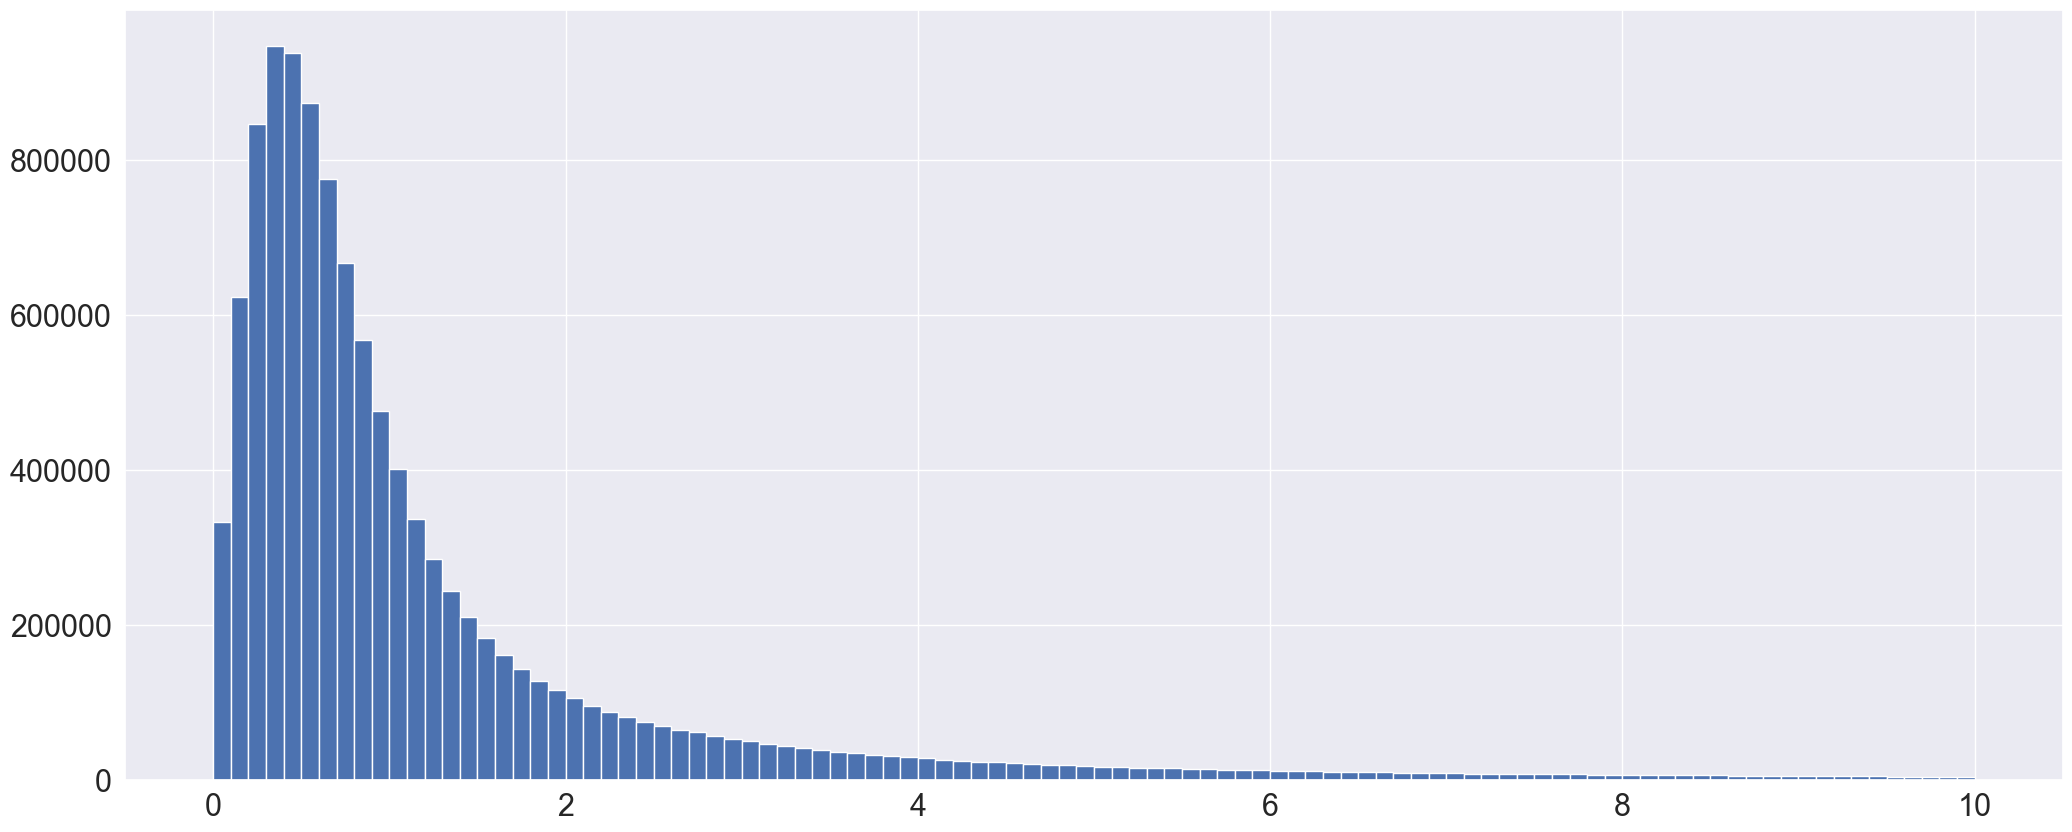

In [103]:
# Overall distribution of distances 

plt.hist(dist_vec, bins=100, range=[0,10])
plt.show()

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

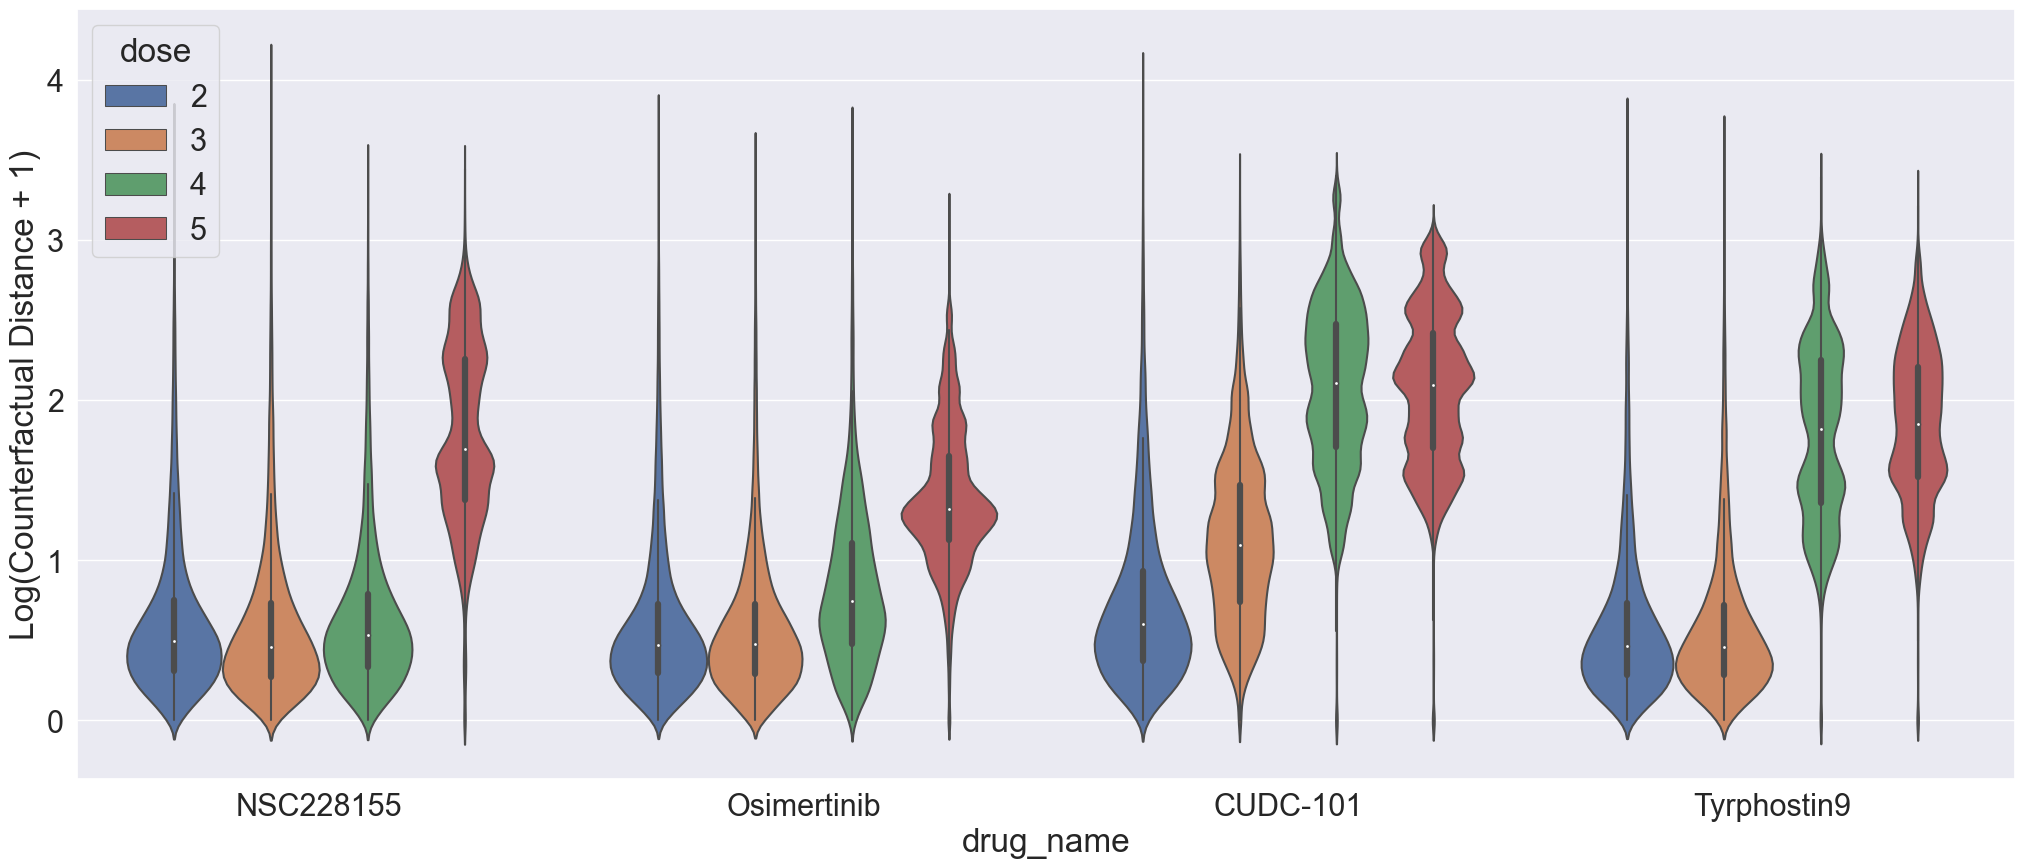

In [116]:
# Drug-dose-specific distribution of distances 

counterfactual_df = pd.DataFrame(np.log(dist_vec+1), 
                                 columns=['Log(Counterfactual Distance + 1)'],
                                 index=drugnamedose_anno
                                )
counterfactual_df['drug_name'] = [i[:-4] for i in drugnamedose_anno]
counterfactual_df['dose'] = [int(i[-3:-2]) for i in drugnamedose_anno]

violin_df = counterfactual_df[(counterfactual_df['drug_name'] == 'Tyrphostin9') | 
                              (counterfactual_df['drug_name'] == 'Osimertinib') | 
                              (counterfactual_df['drug_name'] == 'NSC228155') | 
                              (counterfactual_df['drug_name'] == 'CUDC-101') 
                 ]

sns.set_theme(rc={'figure.figsize':(25,10)})
sns.set(font_scale=2)

sns.violinplot(data=violin_df, 
               x="drug_name", 
               y="Log(Counterfactual Distance + 1)",
               hue='dose',
               width=0.8
              )
plt.show()

In [118]:
# save cell-level sample-sample distances 

pd.DataFrame(dist_vec, 
             columns=['Counterfactual Distance'],
             index=drugnamedose_anno
            ).to_csv('BT333_SingleCellCounterfactualSampleDistance.csv')

In [15]:
# create a DataFrame for mean sample-sample distances across all cells

drug_dist_df = pd.DataFrame(
        cell_dists['cell'].mean(axis=0), 
        columns = cell_dists['sample_x'].values,
        index = cell_dists['sample_x'].values
)
drug_dist_df

,AC480_2.0,AC480_3.0,AC480_5.0,AEE788_2.0,AEE788_3.0,AEE788_4.0,AEE788_5.0,AG-1478_2.0,AG-1478_3.0,AG-1478_4.0,...,WZ3146_4.0,WZ3146_5.0,WZ4002_2.0,WZ4002_3.0,WZ4002_4.0,WZ4002_5.0,WZ8040_2.0,WZ8040_3.0,WZ8040_4.0,WZ8040_5.0
AC480_2.0,0.000000,0.516419,0.729878,0.515578,0.534869,0.981950,1.039858,0.519317,0.622879,1.050043,...,1.442293,1.905362,0.528379,0.528113,0.558944,0.783854,0.521892,0.548622,0.873149,1.128558
AC480_3.0,0.516419,0.000000,0.726839,0.518235,0.533862,0.977575,1.034395,0.512805,0.622667,1.045997,...,1.434508,1.892414,0.517447,0.522488,0.558070,0.780164,0.514492,0.547790,0.864946,1.119810
AC480_5.0,0.729878,0.726839,0.000000,0.667987,0.599179,0.514601,0.522882,0.729242,0.541713,0.537029,...,0.868587,1.386292,0.751304,0.706276,0.550829,0.479296,0.735592,0.662187,0.488049,0.576476
AEE788_2.0,0.515578,0.518235,0.667987,0.000000,0.514318,0.898166,0.949040,0.520791,0.590094,0.962722,...,1.352029,1.825447,0.537624,0.520387,0.529443,0.713304,0.526730,0.533403,0.798418,1.032066
AEE788_3.0,0.534869,0.533862,0.599179,0.514318,0.000000,0.796757,0.829244,0.536544,0.558682,0.852280,...,1.218587,1.696497,0.557315,0.523887,0.506781,0.635199,0.544023,0.523148,0.706524,0.911590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WZ4002_5.0,0.783854,0.780164,0.479296,0.713304,0.635199,0.506614,0.504959,0.782525,0.577221,0.512274,...,0.802986,1.306149,0.810282,0.761065,0.570372,0.000000,0.790720,0.717356,0.491930,0.536336
WZ8040_2.0,0.521892,0.514492,0.735592,0.526730,0.544023,0.982024,1.032064,0.503542,0.627954,1.054850,...,1.423588,1.863029,0.508448,0.513965,0.567948,0.790720,0.000000,0.554011,0.867129,1.120776
WZ8040_3.0,0.548622,0.547790,0.662187,0.533403,0.523148,0.900840,0.935347,0.543163,0.590867,0.972335,...,1.342615,1.804172,0.568886,0.517487,0.544899,0.717356,0.554011,0.000000,0.783377,1.033383
WZ8040_4.0,0.873149,0.864946,0.488049,0.798418,0.706524,0.473206,0.478459,0.862484,0.575554,0.494935,...,0.837335,1.378815,0.885107,0.838803,0.633742,0.491930,0.867129,0.783377,0.000000,0.535416


In [17]:
# save sample-sample dist matrix

drug_dist_df.to_csv('bt333_mrvi_normalized_dist_df_namedosesample_attention.csv')

In [3]:
# LOAD THE SAMPLE-SAMPLE DISTANCES DF, CLUSTERING AND MULTIVAR DE ANALYSIS RESULTS (if available)

import pickle
import csv

drug_dist_df = pd.read_csv('bt333_mrvi_normalized_dist_df_namedosesample_attention.csv', index_col=0)

drug_cluster_labels = pd.read_csv('bt333_normalized_attention_drug_cluster_labels.csv', index_col=0)

with open('large_drugscreen_bt333_clusterwise_multivar_res_normalized_attention_namedosesample.pkl', 'rb') as inp:
    cluster_wise_multivar_res = pickle.load(inp)

topgenes_df = pd.read_csv('bt333_topgenes_normalized_attention_dist.csv', index_col=0)

In [4]:
# Save the drug-dose groupings across DRCs as a dataframe 

DRC_drugdose_dict = {}

for cluster in np.unique(drug_cluster_labels['cluster']): 
    DRC_drugdose_dict[str(cluster)] = drug_cluster_labels.index[drug_cluster_labels['cluster'] == cluster].tolist()

DRC_drugdose_df = pd.DataFrame.from_dict(DRC_drugdose_dict, orient='index').T
DRC_drugdose_df.to_csv('bt333_DRC_drugdose_table.csv')
    
DRC_drugdose_df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,CUDC-101_4.0,CUDC-101_5.0,Ibrutinib_5.0,Dacomitinib_5.0,Butein_5.0,CUDC-101_3.0,AC480_5.0,AG-490_5.0,AC480_2.0,AZ5104_3.0,...,CNX-2006_5.0,WZ3146_5.0,AZ5104_5.0,Naquotinib_5.0,EGFRInhibitor_5.0,Puromycin_5.0,DZD9008_5.0,Poziotinib_5.0,AP26113-analog_5.0,Mobocertinib_5.0
1,None,None,TAS6417_5.0,PD168393_5.0,Pelitinib_5.0,None,Alflutinib_3.0,AG494_5.0,AC480_3.0,Afatinib_2.0,...,None,None,Osimertinib_5.0,None,None,None,MTX-211_5.0,None,Brigatinib_5.0,None
2,None,None,WZ3146_4.0,Rociletinib_5.0,None,None,Allitinib_2.0,AG555_5.0,AEE788_2.0,Afatinib_3.0,...,None,None,None,None,None,None,None,None,Naquotinib_4.0,None
3,None,None,WZ8040_5.0,None,None,None,Avitinib_4.0,None,AEE788_3.0,Allitinib_5.0,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,BDTX-189_3.0,None,AG-1478_2.0,DZD9008_4.0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,None,None,None,None,None,None,None,None,WZ3146_3.0,None,...,None,None,None,None,None,None,None,None,None,None
173,None,None,None,None,None,None,None,None,WZ4002_2.0,None,...,None,None,None,None,None,None,None,None,None,None
174,None,None,None,None,None,None,None,None,WZ4002_3.0,None,...,None,None,None,None,None,None,None,None,None,None
175,None,None,None,None,None,None,None,None,WZ8040_2.0,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# HEATMAP: Sample-Sample dist matrix 

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

cluster_method = 'complete'

row_linkage = hierarchy.linkage(
    distance.pdist(drug_dist_df), 
    method=cluster_method
)

col_linkage = row_linkage

# row_col_labels = fcluster(col_linkage, t=5, criterion='distance')
row_col_labels = np.array([i[0] for i in drug_cluster_labels.values.tolist()])
lut = dict(zip(set(row_col_labels), sns.hls_palette(len(set(row_col_labels)), l=0.5, s=0.8)))
row_col = pd.DataFrame(row_col_labels)[0].map(lut)

labels2 = np.array([i[-3:] for i in drug_dist_df.columns.values])
lut2 = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.7)))
row_col2 = pd.DataFrame(labels2)[0].map(lut2)

g = sns.clustermap(drug_dist_df, 
                   row_linkage=row_linkage, 
                   col_linkage=col_linkage, 
                   method=cluster_method,
                   row_colors = [row_col, row_col2],
                   col_colors = [row_col, row_col2],
                   annot=True,
                   figsize=(50, 50), 
                   cmap='viridis',
                   yticklabels=True,xticklabels=True)

from matplotlib.pyplot import gcf

for label in np.unique(row_col_labels):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Drug cluster', loc="center",
                               bbox_to_anchor=(0.1, 0.9), bbox_transform=gcf().transFigure)

for label in np.unique(labels2):
    g.ax_row_dendrogram.bar(0, 0, color=lut2[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='Dose', loc="center",
                               bbox_to_anchor=(0.12, 0.9), bbox_transform=gcf().transFigure)

plt.show()

In [ ]:
# Cell-level drug cluster assignment 

drug_cluster = pd.DataFrame(row_col_labels,
                            index = drug_dist_df.index,
                            columns = ['cluster'])

donor_cluster = np.zeros((adata_mini.obsm['X_BT333_mini_z'].shape[0],1))

for i in range(adata_mini.obsm['X_BT333_mini_z'].shape[0]):
    donor_cluster[i] = drug_cluster.loc[adata_mini[i].obs['drug_name_dose'][0]][0]
    
donor_cluster = donor_cluster[:,0].tolist()
np.unique(donor_cluster)

In [ ]:
# Silhouette scores for drug cluster assignment 

from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

n_clusters = len(np.unique(drug_cluster))
stability = silhouette_score(drug_dist_df.values, drug_cluster, metric='euclidean')

# Silhouette plot
        
fig_sil, ax1 = plt.subplots(1, 1)
fig_sil.set_size_inches(18, 7)
ax1.set_xlim([-.1, 1])
ax1.set_ylim([0, len(drug_dist_df.values) + (n_clusters + 1) * 10])

sample_silhouette_values = silhouette_samples(drug_dist_df.values, drug_cluster)
y_lower = 10
for i in range(1,n_clusters+1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[np.where(drug_cluster == i)[0]]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for drug clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Drug cluster")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=stability, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])

plt.suptitle(
    "Silhouette analysis for Drug clustering with %d factors"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)
plt.show()

In [26]:
# Save DRC labels 

drug_cluster.to_csv('bt333_normalized_attention_drug_cluster_labels.csv')

In [ ]:
train_adata = adata_mini.copy() 
n_clusters = len(np.unique(drug_cluster))

train_adata.obs["donor_cluster"] = [int(x) for x in donor_cluster]
train_adata.obs.loc[train_adata.obs.drug_name == 'DMSO', "donor_cluster"] = -1

for cluster_i in range(1, n_clusters + 1):
    train_adata.obs[f"donor_cluster_{cluster_i}"] = (
        train_adata.obs["donor_cluster"] == cluster_i
    ).astype(int)
    
obs_df = train_adata.obs.copy()
obs_df = obs_df.loc[~obs_df._scvi_sample.duplicated("first")]

model.donor_info = obs_df.set_index("_scvi_sample").sort_index()

sub_train_adata = train_adata[train_adata.obs["donor_cluster"] != "nan"]
sub_train_adata.obs["_indices"] = np.arange(sub_train_adata.shape[0])
sub_train_adata.obs

In [34]:
# Multivariate DE Analysis

cluster_wise_multivar_res = {}
for cluster_i in range(1, n_clusters + 1):
    print('Performing multivariate analysis for cluster %d...'%cluster_i)
    cluster_sub_train_adata = sub_train_adata[
        (sub_train_adata.obs["donor_cluster"] == cluster_i) 
        | (sub_train_adata.obs["donor_cluster"] == -1)
    ].copy()
    
    cluster_multivar_res = model.perform_multivariate_analysis(
        cluster_sub_train_adata,
        donor_keys=[f"donor_cluster_{cluster_i}"],
        batch_size=32,
        store_lfc=True,
    )
    cluster_wise_multivar_res[cluster_i] = cluster_multivar_res

Performing multivariate analysis for cluster 1...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|█████████████████████████████████████████| 119/119 [11:17<00:00,  5.69s/it]

Performing multivariate analysis for cluster 2...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 121/121 [11:21<00:00,  5.63s/it]

Performing multivariate analysis for cluster 3...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 129/129 [12:12<00:00,  5.68s/it]

Performing multivariate analysis for cluster 4...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 126/126 [11:54<00:00,  5.67s/it]

Performing multivariate analysis for cluster 5...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 123/123 [11:31<00:00,  5.62s/it]

Performing multivariate analysis for cluster 6...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 121/121 [11:13<00:00,  5.57s/it]

Performing multivariate analysis for cluster 7...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 206/206 [19:09<00:00,  5.58s/it]

Performing multivariate analysis for cluster 8...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 129/129 [13:01<00:00,  6.05s/it]


Performing multivariate analysis for cluster 9...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|███████████████████████████████████████| 855/855 [1:22:49<00:00,  5.81s/it]


Performing multivariate analysis for cluster 10...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|█████████████████████████████████████████| 184/184 [17:20<00:00,  5.65s/it]

Performing multivariate analysis for cluster 11...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 134/134 [13:02<00:00,  5.84s/it]

Performing multivariate analysis for cluster 12...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 208/208 [19:39<00:00,  5.67s/it]


Performing multivariate analysis for cluster 13...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|█████████████████████████████████████████| 123/123 [11:33<00:00,  5.64s/it]

Performing multivariate analysis for cluster 14...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 120/120 [11:14<00:00,  5.62s/it]

Performing multivariate analysis for cluster 15...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 122/122 [11:30<00:00,  5.66s/it]

Performing multivariate analysis for cluster 16...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 120/120 [11:18<00:00,  5.65s/it]

Performing multivariate analysis for cluster 17...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 119/119 [11:05<00:00,  5.59s/it]

Performing multivariate analysis for cluster 18...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 122/122 [11:16<00:00,  5.54s/it]

Performing multivariate analysis for cluster 19...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 120/120 [11:15<00:00,  5.63s/it]

Performing multivariate analysis for cluster 20...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 119/119 [11:12<00:00,  5.65s/it]

Performing multivariate analysis for cluster 21...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 118/118 [11:03<00:00,  5.63s/it]

Performing multivariate analysis for cluster 22...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 123/123 [11:23<00:00,  5.55s/it]

Performing multivariate analysis for cluster 23...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 120/120 [11:11<00:00,  5.59s/it]

Performing multivariate analysis for cluster 24...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 123/123 [11:27<00:00,  5.59s/it]

Performing multivariate analysis for cluster 25...
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        



100%|█████████████████████████████████████████| 118/118 [11:05<00:00,  5.64s/it]


In [35]:
# SAVE THE MULTIVARIATE DE ANALYSIS RESULTS

import pickle

with open('large_drugscreen_bt333_clusterwise_multivar_res_normalized_attention_namedosesample.pkl', 'wb') as outp:
    pickle.dump(cluster_wise_multivar_res, outp, pickle.HIGHEST_PROTOCOL)

cluster_wise_multivar_res

{1: <xarray.Dataset>
 Dimensions:      (cell_name: 3808, covariate: 1, latent_dim: 30, gene: 2475)
 Coordinates:
   * cell_name    (cell_name) object '35' '44' '58' ... '128821' '128826'
   * covariate    (covariate) <U15 'donor_cluster_1'
   * latent_dim   (latent_dim) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
   * gene         (gene) object 'SOX2' 'PPP2R5A' 'ARPC4' ... 'TTC28' 'TNFRSF19'
 Data variables:
     beta         (cell_name, covariate, latent_dim) float32 -0.07231 ... 0.1649
     effect_size  (cell_name, covariate) float32 689.8 564.3 ... 541.0 599.1
     pvalue       (cell_name, covariate) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     padj         (cell_name, covariate) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     lfc          (covariate, cell_name, gene) float32 -0.05848 ... 0.04136
     lfc_std      (covariate, cell_name, gene) float32 0.00165 ... 0.001424
     pde          (covariate, cell_name, gene) float32 0.0 0.0 0.0 ... 0.0 0.0,
 2: <xarray.Dataset>
 Dimensio

# DEGs for drug response class 1: 1219
# DEGs for drug response class 2: 1278
# DEGs for drug response class 3: 83
# DEGs for drug response class 4: 139
# DEGs for drug response class 5: 162
# DEGs for drug response class 6: 61
# DEGs for drug response class 7: 1
# DEGs for drug response class 8: 44
# DEGs for drug response class 9: 4
# DEGs for drug response class 10: 4
# DEGs for drug response class 11: 68
# DEGs for drug response class 12: 19
# DEGs for drug response class 13: 730
# DEGs for drug response class 14: 530
# DEGs for drug response class 15: 372
# DEGs for drug response class 16: 475
# DEGs for drug response class 17: 440
# DEGs for drug response class 18: 476
# DEGs for drug response class 19: 550
# DEGs for drug response class 20: 367
# DEGs for drug response class 21: 400
# DEGs for drug response class 22: 257
# DEGs for drug response class 23: 218
# DEGs for drug response class 24: 309
# DEGs for drug response class 25: 306
Avg # DEGs: 340


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,...,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25
SOX2,-0.143322,-0.168565,0.043121,0.026123,0.058398,-0.034926,-0.011140,0.029641,-0.013452,-0.002229,...,0.066727,0.093884,0.004524,0.065469,0.043934,0.116662,0.022626,0.074070,0.062667,-0.000038
PPP2R5A,0.120411,0.131274,-0.044067,-0.078970,-0.054548,0.047221,0.006728,-0.021274,0.019096,-0.004331,...,-0.153795,-0.133621,-0.170911,-0.170832,-0.064042,-0.063133,-0.112950,-0.075992,-0.113341,-0.145559
ARPC4,0.054008,0.098901,-0.004688,-0.023396,-0.066385,0.059876,0.017999,-0.040024,0.002847,0.021397,...,-0.066429,-0.064479,-0.077274,-0.084577,-0.146298,-0.112012,-0.048277,-0.032879,-0.041387,-0.060333
LMNB2,-0.013012,-0.013943,0.005533,0.001088,0.000953,0.002988,-0.001593,0.000212,-0.001531,-0.000330,...,0.011502,0.016700,-0.002547,0.011042,0.008942,0.008873,-0.000630,0.013435,0.009018,-0.004417
ZDHHC17,0.225862,0.219824,0.002335,0.013810,0.049284,-0.002657,-0.005264,0.022598,-0.006791,-0.003433,...,-0.009267,0.000591,-0.008418,-0.019955,0.070175,0.047161,0.023084,0.008518,0.004584,0.014382


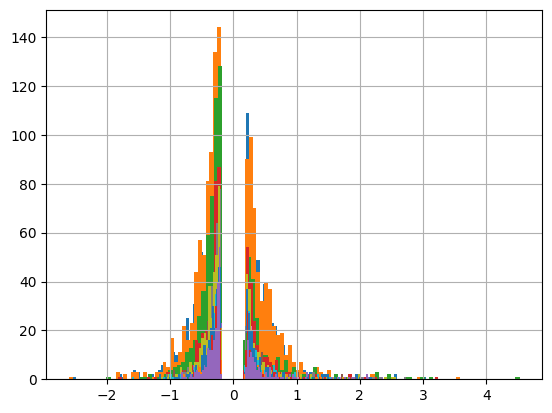

In [67]:
drug_lfc = pd.DataFrame()
de_dfs = {}
full_dfs = {}
lfc_thresh = 0.2
avg_numDEGs = 0

for cluster_i in cluster_wise_multivar_res: 

    betas_ = cluster_wise_multivar_res[cluster_i]['lfc'].transpose("cell_name", "covariate", "gene").loc[{"covariate": f"donor_cluster_{cluster_i}"}].values
    betas_ = (betas_ / np.log(2)).astype('float')

    lfc_df = pd.DataFrame(
            {
                "LFC": betas_.mean(0),
                "LFC_std": betas_.std(0),
                "gene": sub_train_adata.var_names,
                "gene_index": np.arange(sub_train_adata.shape[1]),
            }
        ).assign(absLFC=lambda x: np.abs(x.LFC))
    full_dfs[cluster_i] = lfc_df
    drug_lfc['cluster_%d'%cluster_i] = lfc_df['LFC']
    
    cond = lfc_df.absLFC > lfc_thresh
    # cond = lfc_df.LFC > lfc_thresh
    betas_de = betas_[:, cond]
    obs_de = lfc_df.loc[cond, :].reset_index(drop=True)
    obs_de.LFC.hist(bins=100)
    de_dfs[cluster_i] = obs_de

    de_genes = obs_de.gene.values
    de_genes = [gene for gene in de_genes if str(gene) != "nan"]
    print('# DEGs for drug response class %d: '%cluster_i + str(len(de_genes)))
    avg_numDEGs += len(de_genes)
    
print('Avg # DEGs: ' + str(round(avg_numDEGs/cluster_i)))

drug_lfc.index = cluster_wise_multivar_res[1]['gene']
drug_lfc.head()

In [21]:
# Save MrVI multivariate DE analysis LFCs for DEGs 

drug_lfc.to_csv('bt333_DRC_lfc_01122024.csv')

In [58]:
# write gene signatures to csv 
for cluster_i in cluster_wise_multivar_res: 
    pd.DataFrame(de_dfs[cluster_i]['gene']).to_csv('bt333_DRC%d_up_signature_01242024.csv'%cluster_i)

In [28]:
topgenes_df = pd.DataFrame()
for cluster_i in cluster_wise_multivar_res: 
    a = drug_lfc.iloc[:,cluster_i-1]
    if sum(drug_lfc.iloc[:,cluster_i-1]) == 0.0:
        topgenes_df['z%d'%cluster_i] = ['NaN']*100
    else:
        topgenes_idx = sorted(range(len(a)), key=lambda i: a[i])[-100:]
        topgenes_df['drug_cluster_%d'%cluster_i] = a.index[topgenes_idx].values.tolist()[::-1]

topgenes_df

,drug_cluster_1,drug_cluster_2,drug_cluster_3,drug_cluster_4,drug_cluster_5,drug_cluster_6,drug_cluster_7,drug_cluster_8,drug_cluster_9,drug_cluster_10,...,drug_cluster_16,drug_cluster_17,drug_cluster_18,drug_cluster_19,drug_cluster_20,drug_cluster_21,drug_cluster_22,drug_cluster_23,drug_cluster_24,drug_cluster_25
0,GNAO1,GNAO1,PEG10,PPARA,PPARA,SCAMP1,PEG10,PPARA,STK17A,PEG10,...,DCC,DCC,PPARA,DCC,PPARA,KIAA1161,PPARA,PEG10,DCC,PPARA
1,LMO7,LMO7,PUS7L,DCC,KIAA1161,XPR1,USP19,KIAA1161,TOB2,SS18,...,XPR1,PEG10,XPR1,XPR1,NTRK3,PPARA,TMEM192,DCC,PEG10,TMEM192
2,PPARA,SCAMP1,DCC,GFAP,CTNNAL1,LMO7,SS18,TM2D1,LEF1,UST,...,PPARA,XPR1,DCC,PPARA,CTNNAL1,GOLIM4,GFAP,PUS7L,XPR1,XPR1
3,SCAMP1,PPARA,UST,TMEM192,TMEM192,GNAO1,LEF1,CTNNAL1,EGFR,USP19,...,TMEM192,PPARA,TMEM192,TMEM192,TMEM192,SFI1,CTNNAL1,LRP8,PPARA,GFAP
4,GOLIM4,UBP1,DNAJC13,CTNNAL1,GFAP,PPARA,PNPLA2,TMEM192,CHD6,LARP6,...,GFAP,GFAP,GFAP,GFAP,FUBP3,NTRK3,DCC,DNAJC13,GFAP,DCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,YKT6,RUSC2,PIK3R3,PPP1R12B,TENM1,PEG3,NDST1,WTAP,NCOR2,NRIP1,...,SLC16A1,MAPKAPK3,PLCB1,GBE1,LMCD1-AS1,FRMD6,AGL,WDR4,AKAP12,MED25
96,PLPP3,EMC6,SLC9A8,MIR222HG,CAV1,CENPE,FAM222B,EFNB2,TPM1,SYNPO,...,ABR,SLC4A4,DCXR,DCXR,TMEM132B,PTK7,SKP2,ELMOD1,P2RX7,SLC4A4
97,ARAP3,CUEDC1,PPP1R12B,NR3C1,ADAM19,MZT1,CFAP161,IPP,SLC5A3,MSRA,...,MIR222HG,AP3M2,SEMA3C,ITGA10,SRGAP3,NCKAP5L,INTS3,IMMP2L,CTIF,CLN6
98,CYSTM1,NR4A1,PMP22,FRMD6,RICTOR,WDR44,SRPX,CUTA,VWA8,CAVIN1,...,ITGA10,MYC,ZNF445,HDAC8,ACAP3,FAM126A,ATR,DNAJC21,HMMR,JAZF1


In [40]:
# SAVE the DE genes, top up-regulated genes and up-regulated gene scores 

import csv

with open('BT333_DE_genes_dict_normalized_attention_dist.csv', 'w') as f: 
    w = csv.DictWriter(f, de_dfs.keys())
    w.writeheader()
    w.writerow(de_dfs)

topgenes_df.to_csv('bt333_topgenes_normalized_attention_dist.csv')

# GSEA

In [68]:
# perform_gsea function 

def perform_gsea(
    genes: list,
    gene_sets: list = None,
    organism: str = "human",
    n_trials_max: int = 20,
    plot: bool = False,
    plot_sortby: str = "Adjusted P-value",
    plot_ntop: int = 5,
    use_server: bool = True,
):
    """
    Perform GSEA using Enrichr.

    Parameters
    ----------
    genes :
        List of gene symbols to perform GSEA on.
    gene_sets :
        List of gene sets to use for GSEA.
        An exhaustive list of gene sets can be found using `gp.get_library_name()`
    organism :
        Considered organism.
    n_trials_max :
        Maximum number of trials to perform GSEA. Consider increasing if GSEA fails.
    plot :
        Whether to plot the results.
    plot_sortby :
        Key to sort the results by, only used if `plot` is True.
    plot_ntop :
        Number of top results to plot, only used if `plot` is True.
    use_server :
        Whether to use the web server.

    Returns
    -------
    A pandas DataFrame containing the GSEA results.
    If `plot` is True, also returns a plotnine figure.
    """
    try:
        import gseapy as gp
    except ImportError:
        raise ImportError(
            "GSEApy is not installed. Please install it via pip or conda."
        )

    provided_gene_sets = gene_sets is not None
    if not provided_gene_sets:
        gene_sets = [
            "MSigDB_Hallmark_2020",
            "WikiPathway_2021_Human",
            "KEGG_2021_Human",
            "Reactome_2022",
            "GO_Biological_Process_2023",
            "GO_Cellular_Component_2023",
            "GO_Molecular_Function_2023",
        ]
        if not use_server:
            gene_set_dicts = [
                gp.parser.download_library(gene_set_name, "human")
                for gene_set_name in gene_sets
            ]
            gene_set_names = gene_sets
            gene_sets = gene_set_dicts

    if use_server:
        is_done = False
        for _ in range(n_trials_max):
            if is_done:
                break

            try:
                enr = gp.enrichr(
                    gene_list=genes,
                    gene_sets=gene_sets,
                    organism=organism,
                    outdir=None,
                    verbose=False,
                )
                is_done = True
            except:
                time.sleep(3)
                continue
        if not is_done:
            raise ValueError(
                "GSEA failed; please consider increasing `n_trials_max` or try running enrichr manually."
            )
    else:
        enr = gp.enrich(
            gene_list=genes,
            gene_sets=gene_sets,
            outdir=None,
            verbose=False,
        )
    enr_results = enr.results.copy().sort_values("Adjusted P-value")
    enr_results.loc[:, "Significance score"] = -np.log10(
        enr_results.loc[:, "Adjusted P-value"]
    )
    if not use_server and not provided_gene_sets:
        gene_set_mapping = {
            f"gs_ind_{i}": gene_set_name
            for i, gene_set_name in enumerate(gene_set_names)
        }
        enr_results.loc[:, "Gene_set"] = enr_results.loc[:, "Gene_set"].map(
            gene_set_mapping
        )
    if not plot:
        return enr_results

    try:
        import plotnine as p9
    except ImportError:
        raise ImportError(
            "Plotnine is not installed. Please install it via pip or conda."
        )
    plot_df = (
        enr_results.loc[lambda x: x["Adjusted P-value"] < 0.1, :]
        .sort_values(plot_sortby)
        .head(plot_ntop)
        .sort_values("Gene_set")
    )
    fig = (
        p9.ggplot(plot_df, p9.aes(x="Term", y="Significance score", fill="Gene_set"))
        + p9.geom_col()
        + p9.scale_x_discrete(limits=plot_df.Term.tolist())
        + p9.labs(
            x="",
        )
        + p9.theme_classic()
        + p9.theme(
            strip_background=p9.element_blank(),
            axis_text_x=p9.element_text(rotation=45, hjust=1),
            axis_text=p9.element_text(family="sans-serif", size=5),
            axis_title=p9.element_text(family="sans-serif", size=6),
        )
    )
    return enr_results, fig

In [69]:
import gseapy as gp

# GSEA for DE genes
# Load gene sets
plt_vmax = 2

gene_sets = [gp.parser.download_library("MSigDB_Hallmark_2020", "human"),
             gp.parser.download_library('MSigDB_Oncogenic_Signatures', "human"),
             gp.parser.download_library('Kinase_Perturbations_from_GEO_up', "human"),
             gp.parser.download_library('Kinase_Perturbations_from_GEO_down', "human")
            ]

invalid literal for int() with base 10: 'MARCKS'
No objects to concatenate


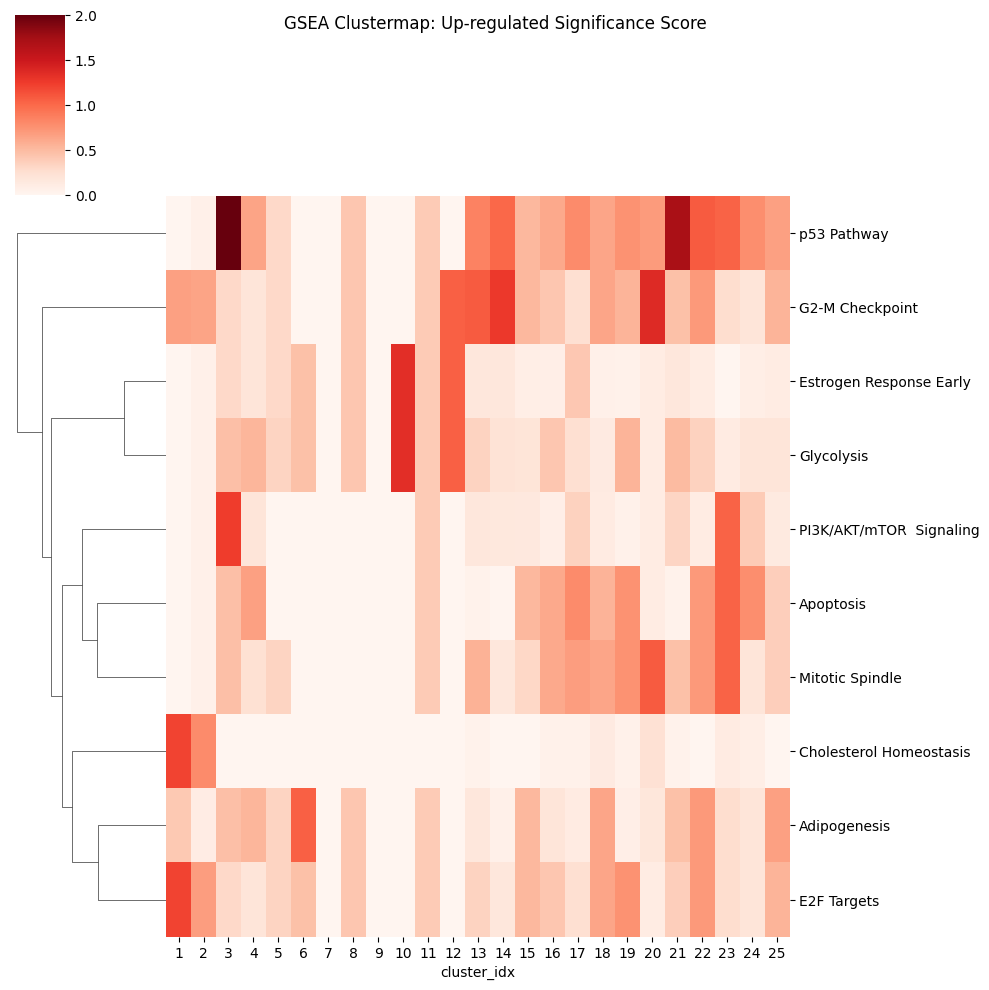

In [70]:
enr_result_dict_up = {}

for cluster_i in cluster_wise_multivar_res:
    de_genes_up = de_dfs[cluster_i][de_dfs[cluster_i].LFC > 0].gene.values
    de_genes_up = [gene for gene in de_genes_up if str(gene) != "nan"]
    try:
        enr_results, fig = perform_gsea(
            de_genes_up, gene_sets=gene_sets, plot=True, use_server=False
        )
        enr_result_dict_up[cluster_i] = enr_results
    except ValueError as e:
        print(e)
        continue

enr_pval_df_records = []
for cluster_idx in range(1, n_clusters + 1):
    if cluster_idx not in enr_result_dict_up:
        enr_pval_df_records.append({"cluster_idx": cluster_idx})
    else:
        enr_cluster_results = enr_result_dict_up[cluster_idx]
        enr_pval_df_records.append(
            {
                "cluster_idx": cluster_idx,
                **enr_cluster_results.pivot(
                    index="Gene_set", columns="Term", values="Significance score"
                )
                .iloc[0]
                .to_dict(),
            }
        )
enr_pval_df = pd.DataFrame.from_records(enr_pval_df_records, index="cluster_idx")
enr_pval_df.fillna(0, inplace=True)

# Plot GSEA heatmap

filtered_enr_pval_df = enr_pval_df.loc[
    :, (enr_pval_df > -np.log10(0.1)).values.any(axis=0)
]

g = sns.clustermap(
        filtered_enr_pval_df.T,
        col_cluster=False,
        yticklabels=True,
        xticklabels=True,
        vmin=0,
        vmax=plt_vmax,
        cmap="Reds",
).fig.suptitle('GSEA Clustermap: Up-regulated Significance Score') 

plt.show()

No objects to concatenate
invalid literal for int() with base 10: 'MARCKS'


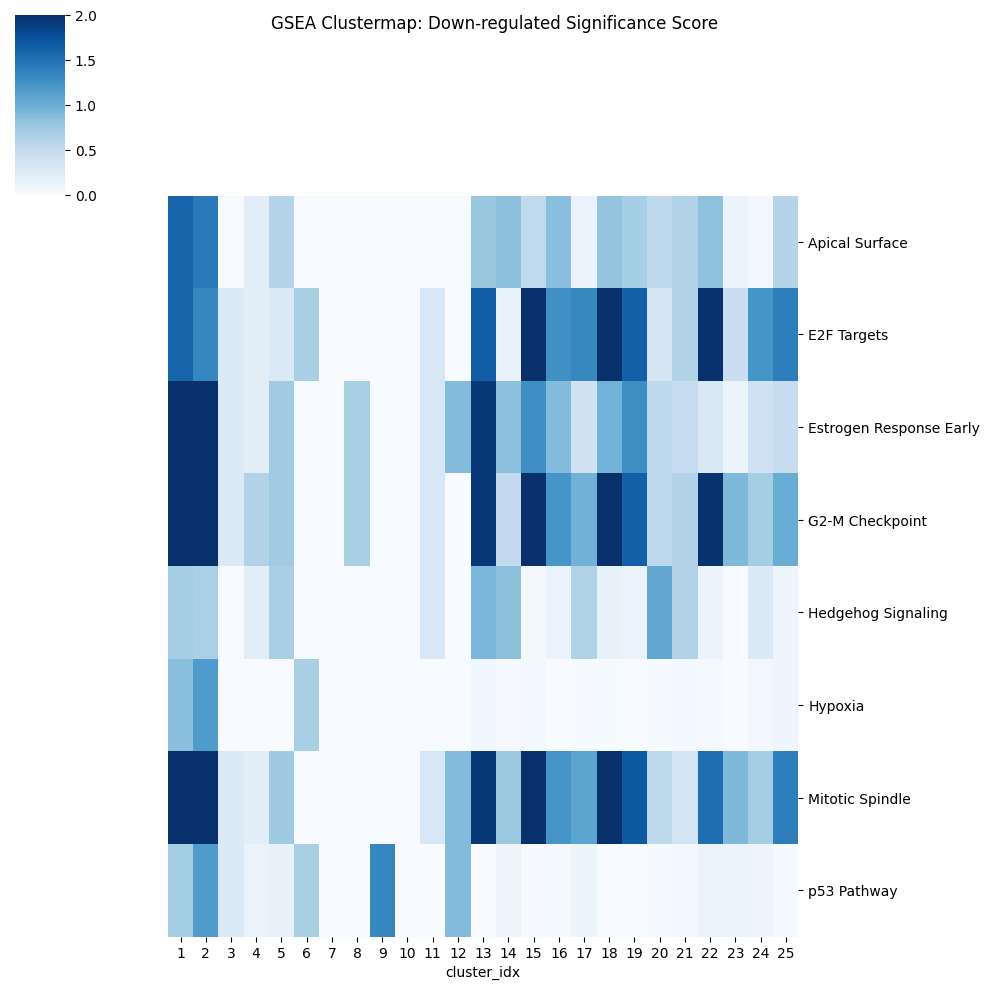

In [74]:
enr_result_dict_down = {}

for cluster_i in cluster_wise_multivar_res:
    de_genes_down = de_dfs[cluster_i][de_dfs[cluster_i].LFC < 0].gene.values
    de_genes_down = [gene for gene in de_genes_down if str(gene) != "nan"]
    try:
        enr_results, fig = perform_gsea(
            de_genes_down, gene_sets=gene_sets, plot=True, use_server=False
        )
        enr_result_dict_down[cluster_i] = enr_results
    except ValueError as e:
        print(e)
        continue

enr_pval_df_records = []
for cluster_idx in range(1, n_clusters + 1):
    if cluster_idx not in enr_result_dict_down:
        enr_pval_df_records.append({"cluster_idx": cluster_idx})
    else:
        enr_cluster_results = enr_result_dict_down[cluster_idx]
        enr_pval_df_records.append(
            {
                "cluster_idx": cluster_idx,
                **enr_cluster_results.pivot(
                    index="Gene_set", columns="Term", values="Significance score"
                )
                .iloc[0]
                .to_dict(),
            }
        )
enr_pval_df = pd.DataFrame.from_records(enr_pval_df_records, index="cluster_idx")
enr_pval_df.fillna(0, inplace=True)

# Plot GSEA heatmap

filtered_enr_pval_df = enr_pval_df.loc[
    :, (enr_pval_df > -np.log10(0.1)).values.any(axis=0)
]

g = sns.clustermap(
        filtered_enr_pval_df.T,
        col_cluster=False,
        row_cluster=False,
        yticklabels=True,
        xticklabels=True,
        vmin=0,
        vmax=plt_vmax,
        cmap="Blues",
).fig.suptitle('GSEA Clustermap: Down-regulated Significance Score') 

plt.show()

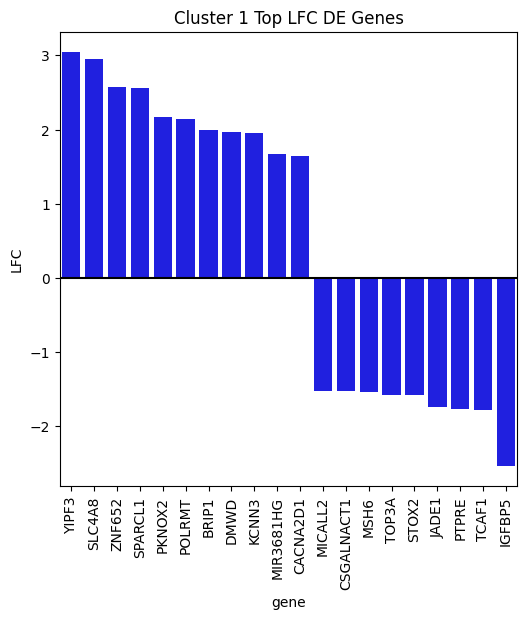

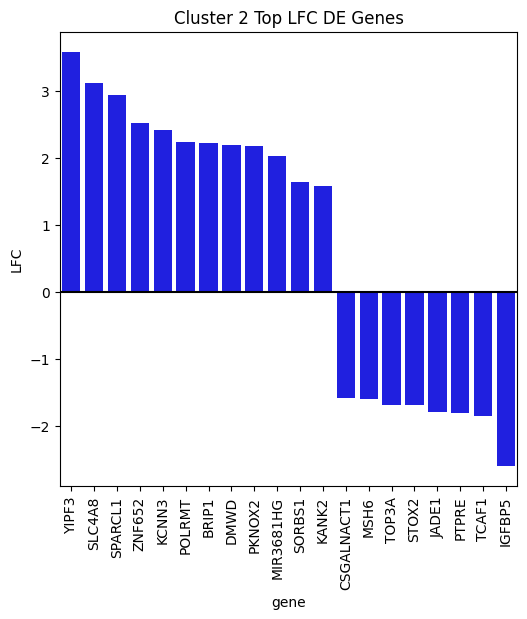

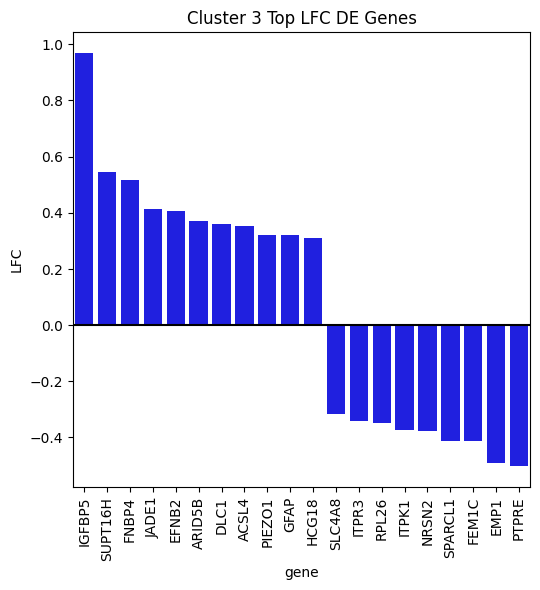

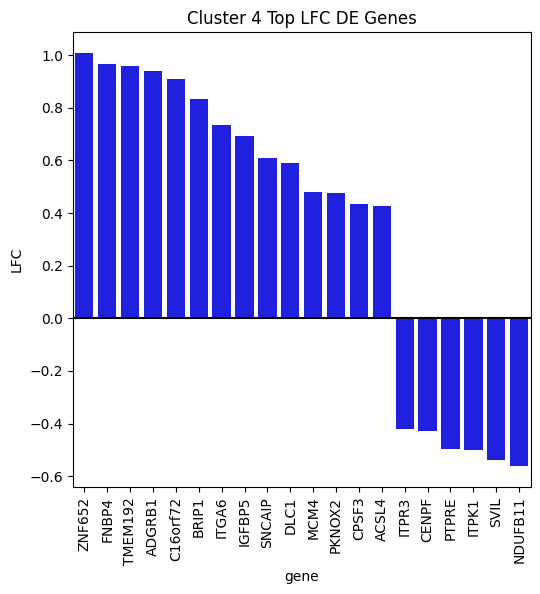

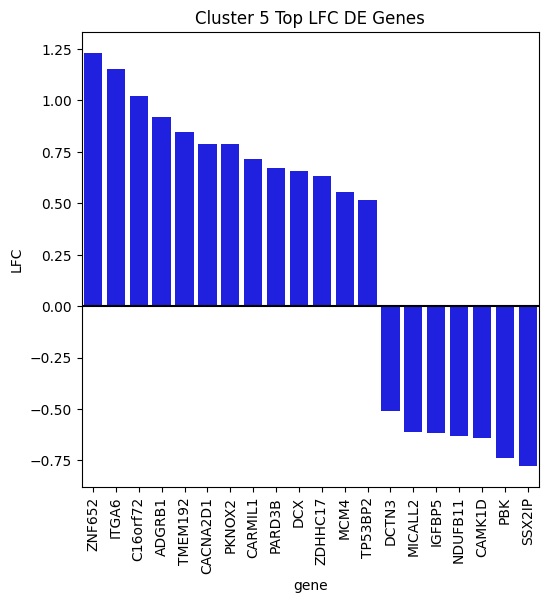

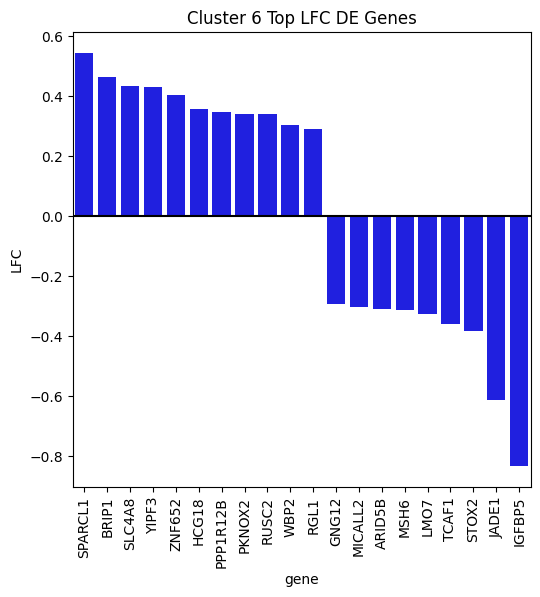

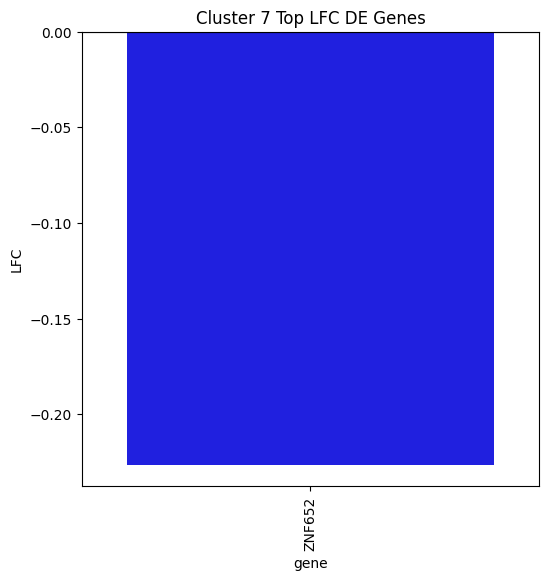

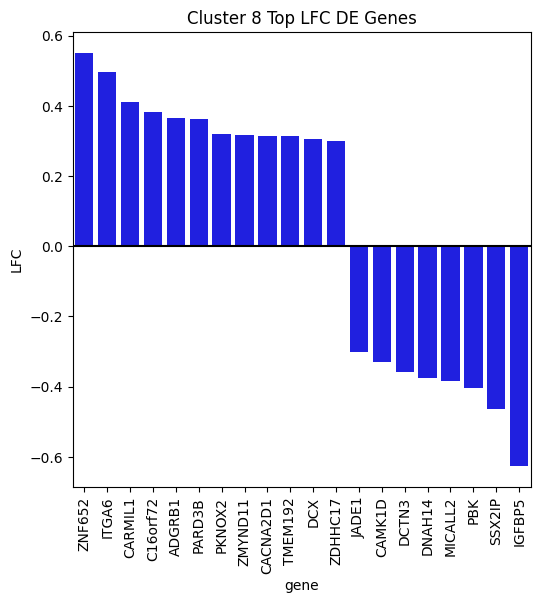

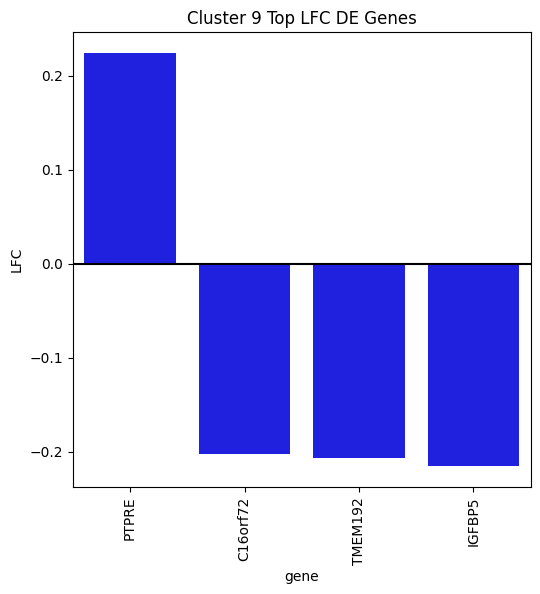

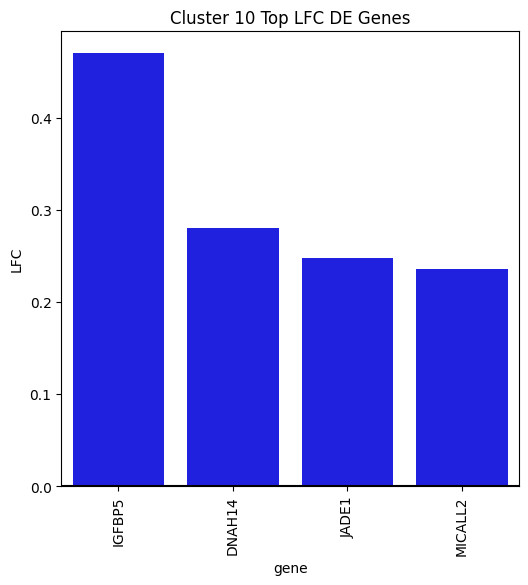

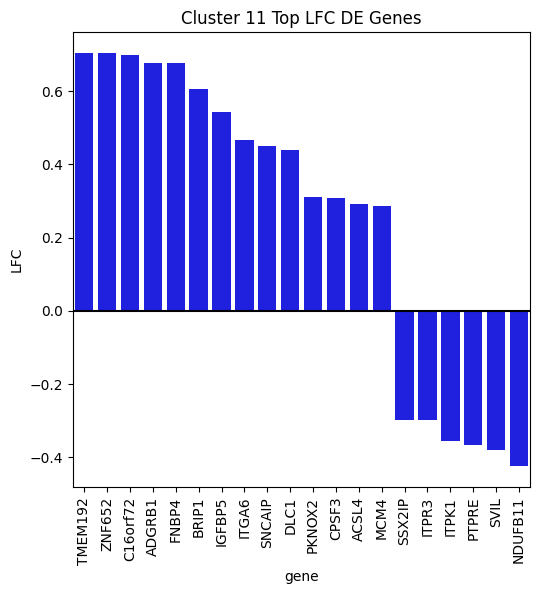

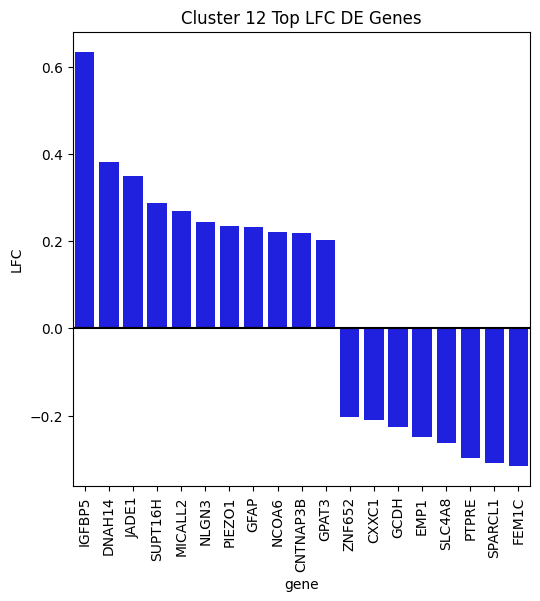

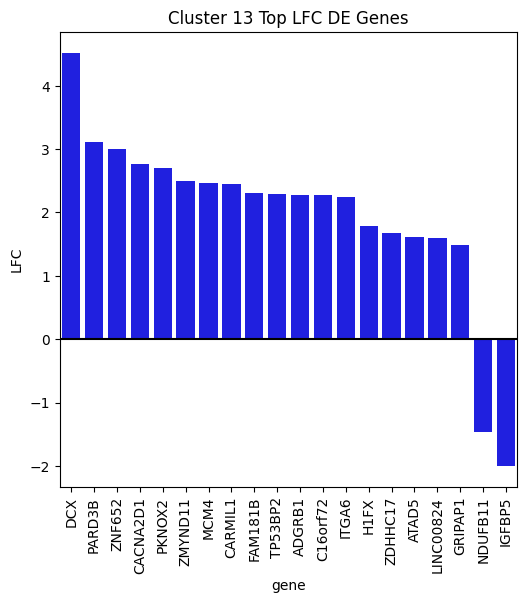

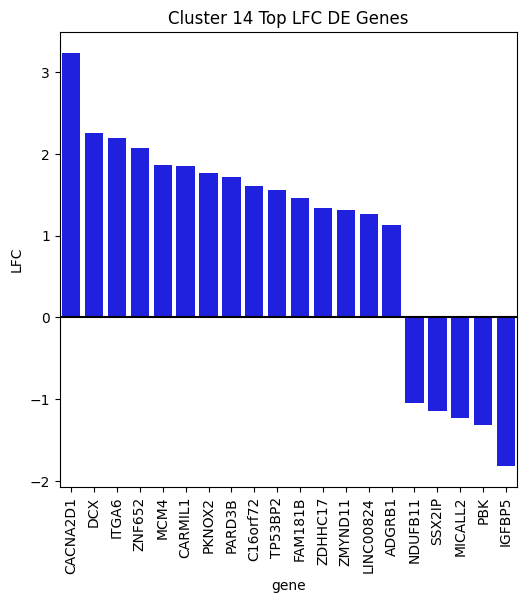

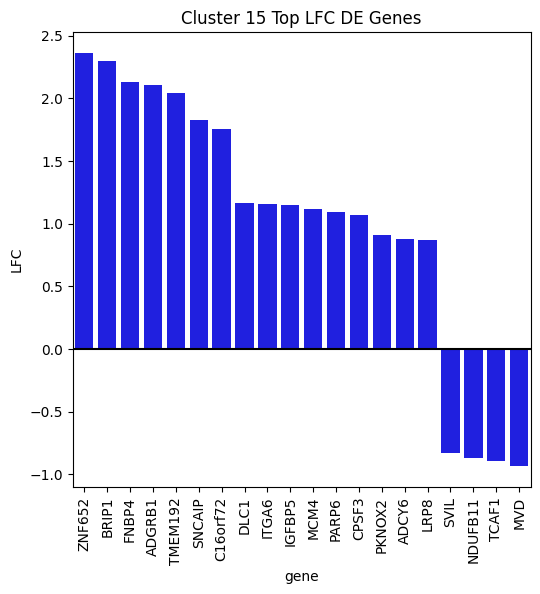

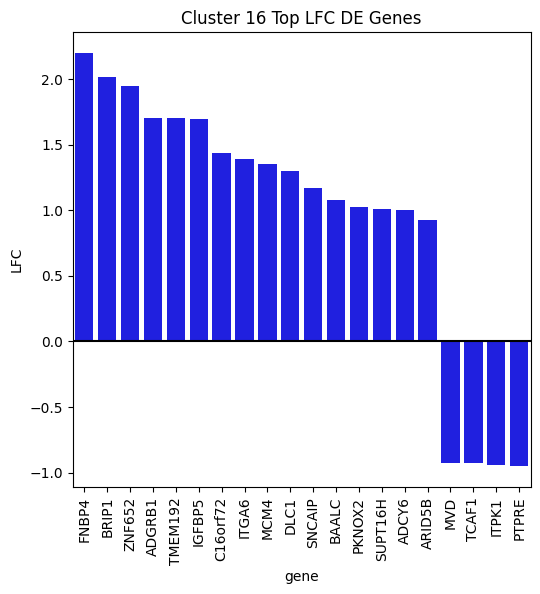

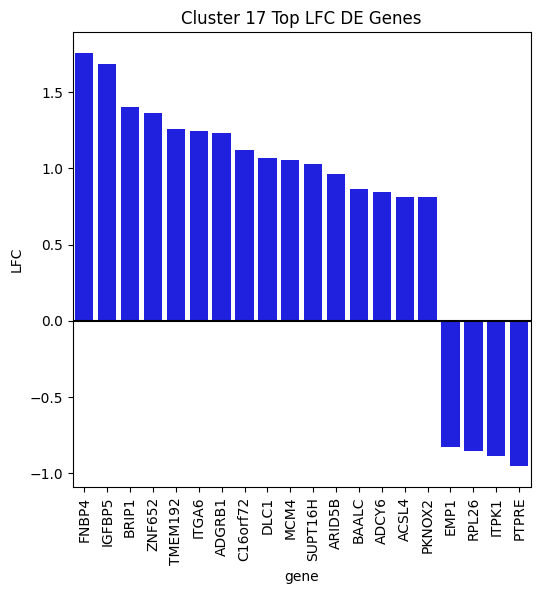

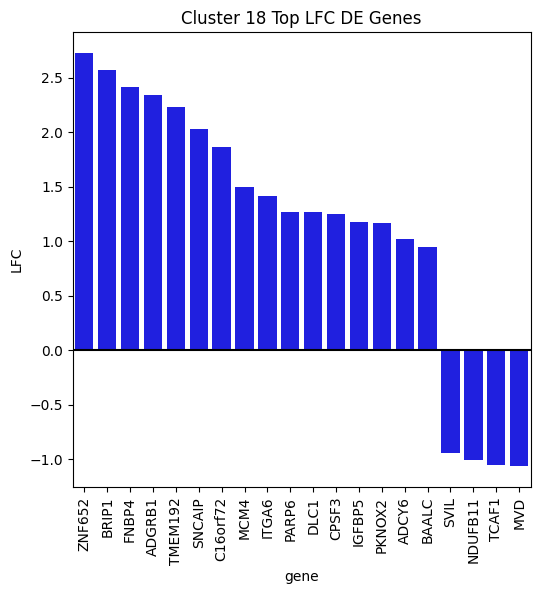

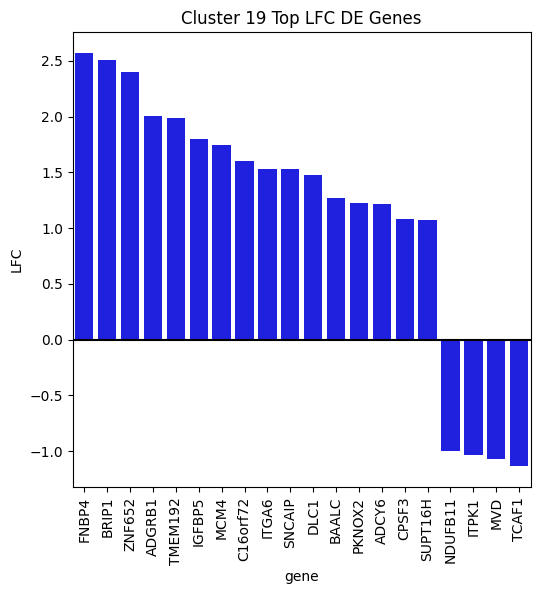

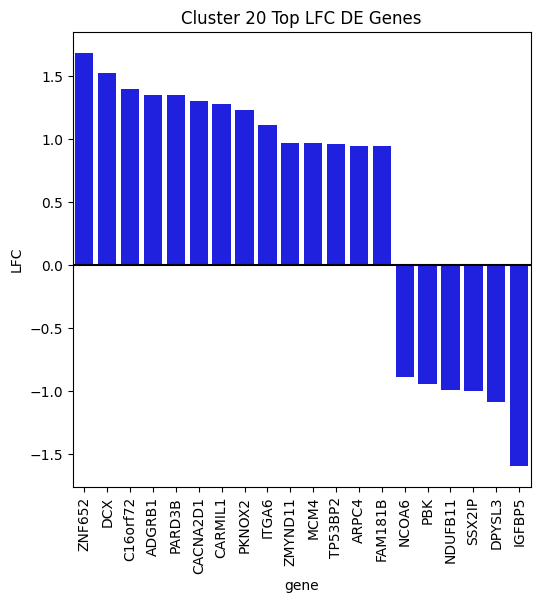

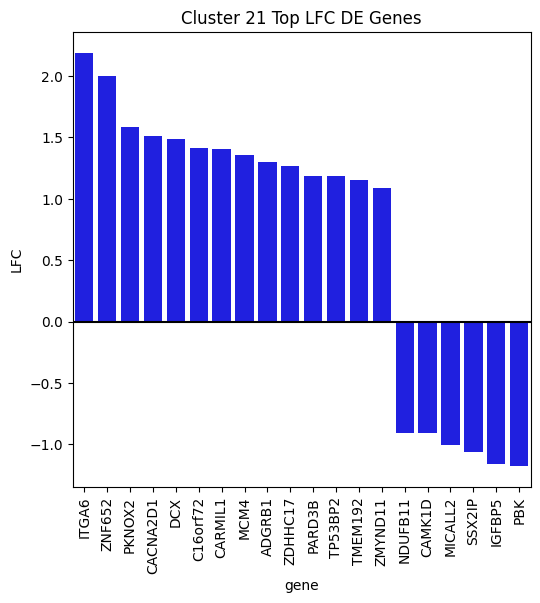

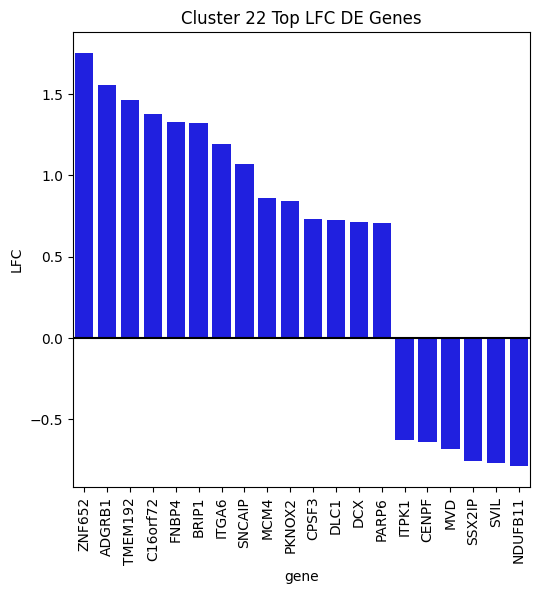

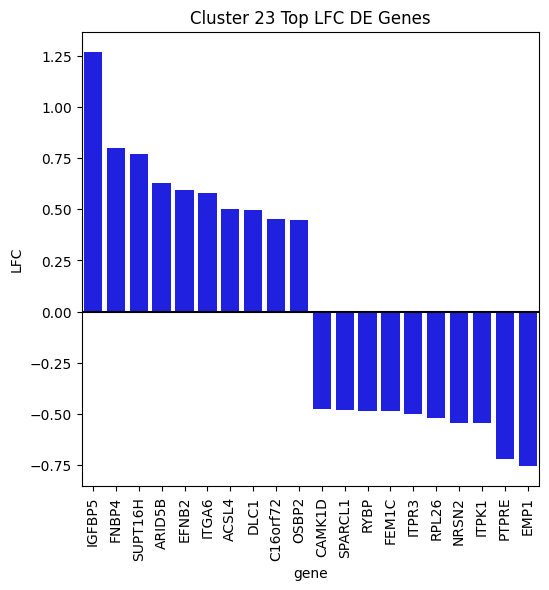

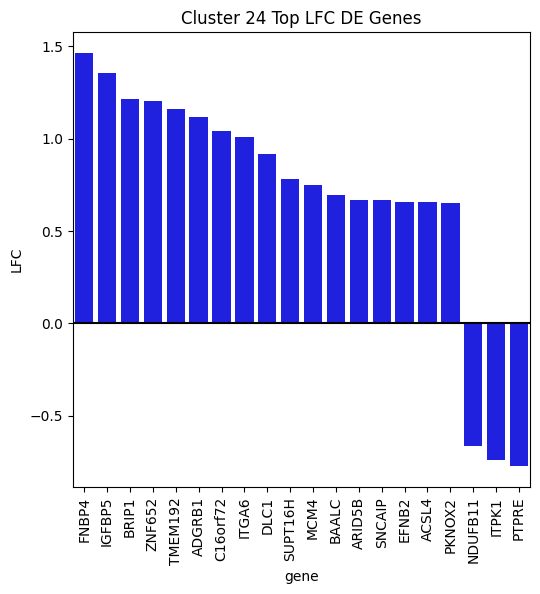

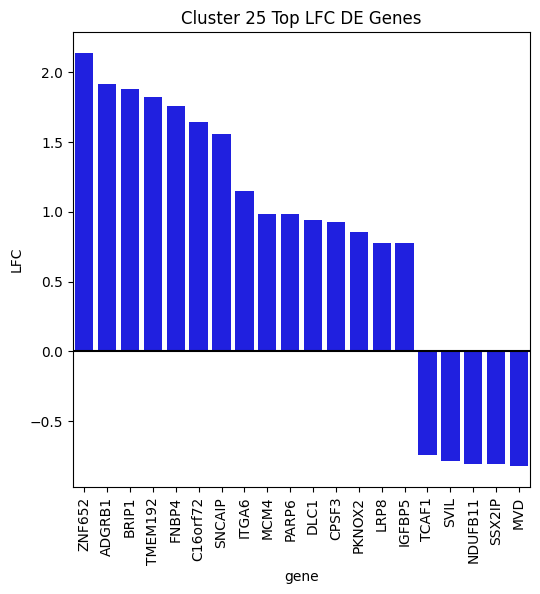

In [28]:
# Cluster wise barplots

INCH_TO_CM = 1 / 2.54

top_de_genes_per_cluster = {}
for cluster_i, de_df in de_dfs.items():
    if de_df.shape[0] == 0:
        continue
    de_df.sort_values("absLFC", ascending=False, inplace=True)
    abr_de_df = de_df[:20]
    top_de_genes_per_cluster[cluster_i] = abr_de_df[:50].gene.values
    abr_de_df.sort_values("LFC", ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(15 * INCH_TO_CM, 15 * INCH_TO_CM))
    sns.barplot(
        x="gene",
        y="LFC",
        color="blue",
        data=abr_de_df,
        ax=ax,
    )
    ax.axhline(y=0, color="black")
    
    # rotate x labels
    ax.set_title(f"Cluster {cluster_i} Top LFC DE Genes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Gene by Drug Response Class Heatmap 

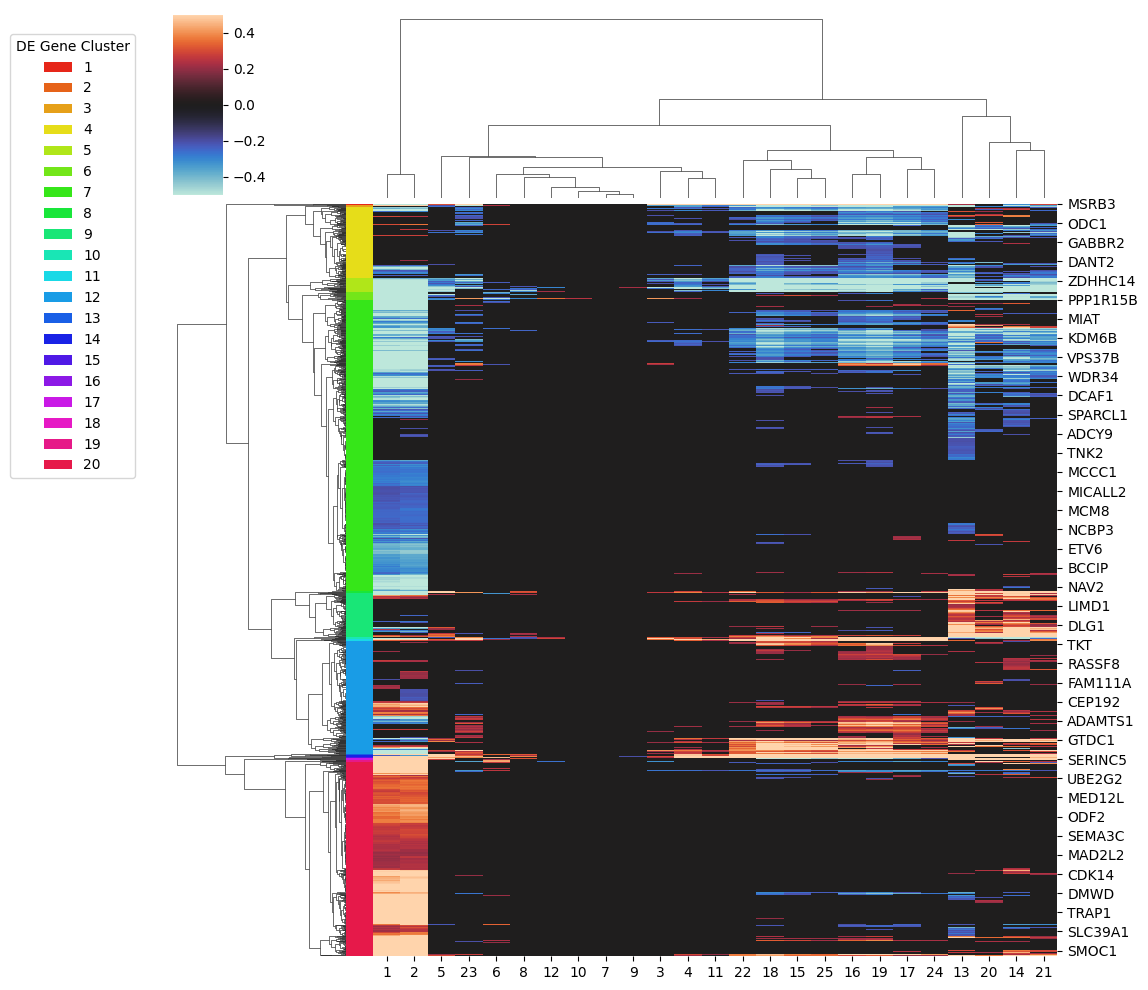

In [33]:
# Create a unionized set of DE genes 
de_genes = set()

for cluster_i in cluster_wise_multivar_res:
    de_genes = de_genes.union(set(de_dfs[cluster_i].gene.values))

# Retrieve LFC values 
drug_class_deg_df = pd.DataFrame(0,index=list(de_genes),columns=np.arange(1,n_clusters+1))
for cluster_i in cluster_wise_multivar_res:
    for g in de_genes:
        if g in de_dfs[cluster_i].gene.values:
            drug_class_deg_df.loc[g,cluster_i] = de_dfs[cluster_i][de_dfs[cluster_i].gene == g].LFC.values[0]
            
# CLUSTERMAP

cluster_method = 'complete'

row_linkage = hierarchy.linkage(
    distance.pdist(drug_class_deg_df), 
    method=cluster_method
)

row_col_labels = fcluster(row_linkage, t=3, criterion='distance')
lut = dict(zip(set(row_col_labels), sns.hls_palette(len(set(row_col_labels)), l=0.5, s=0.8)))
row_col = pd.DataFrame(row_col_labels)[0].map(lut)

g = sns.clustermap(
        drug_class_deg_df,
        cmap='icefire',
        xticklabels=True,
        row_linkage=row_linkage,
        row_colors = [row_col],
        figsize=(10,10),
        vmin=-0.5,
        vmax=0.5
)

for label in np.unique(row_col_labels):
    g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='DE Gene Cluster', loc="lower left",
                               bbox_to_anchor=(-0.15, 0.51), bbox_transform=gcf().transFigure,
                               ncol=1)

plt.show()

In [34]:
# Save the union of MrVI multivariate analysis DEGs

pd.DataFrame(de_genes).to_csv('BT333_de_genes_01182024.csv')

# Drug by Drug Response Class Heatmap

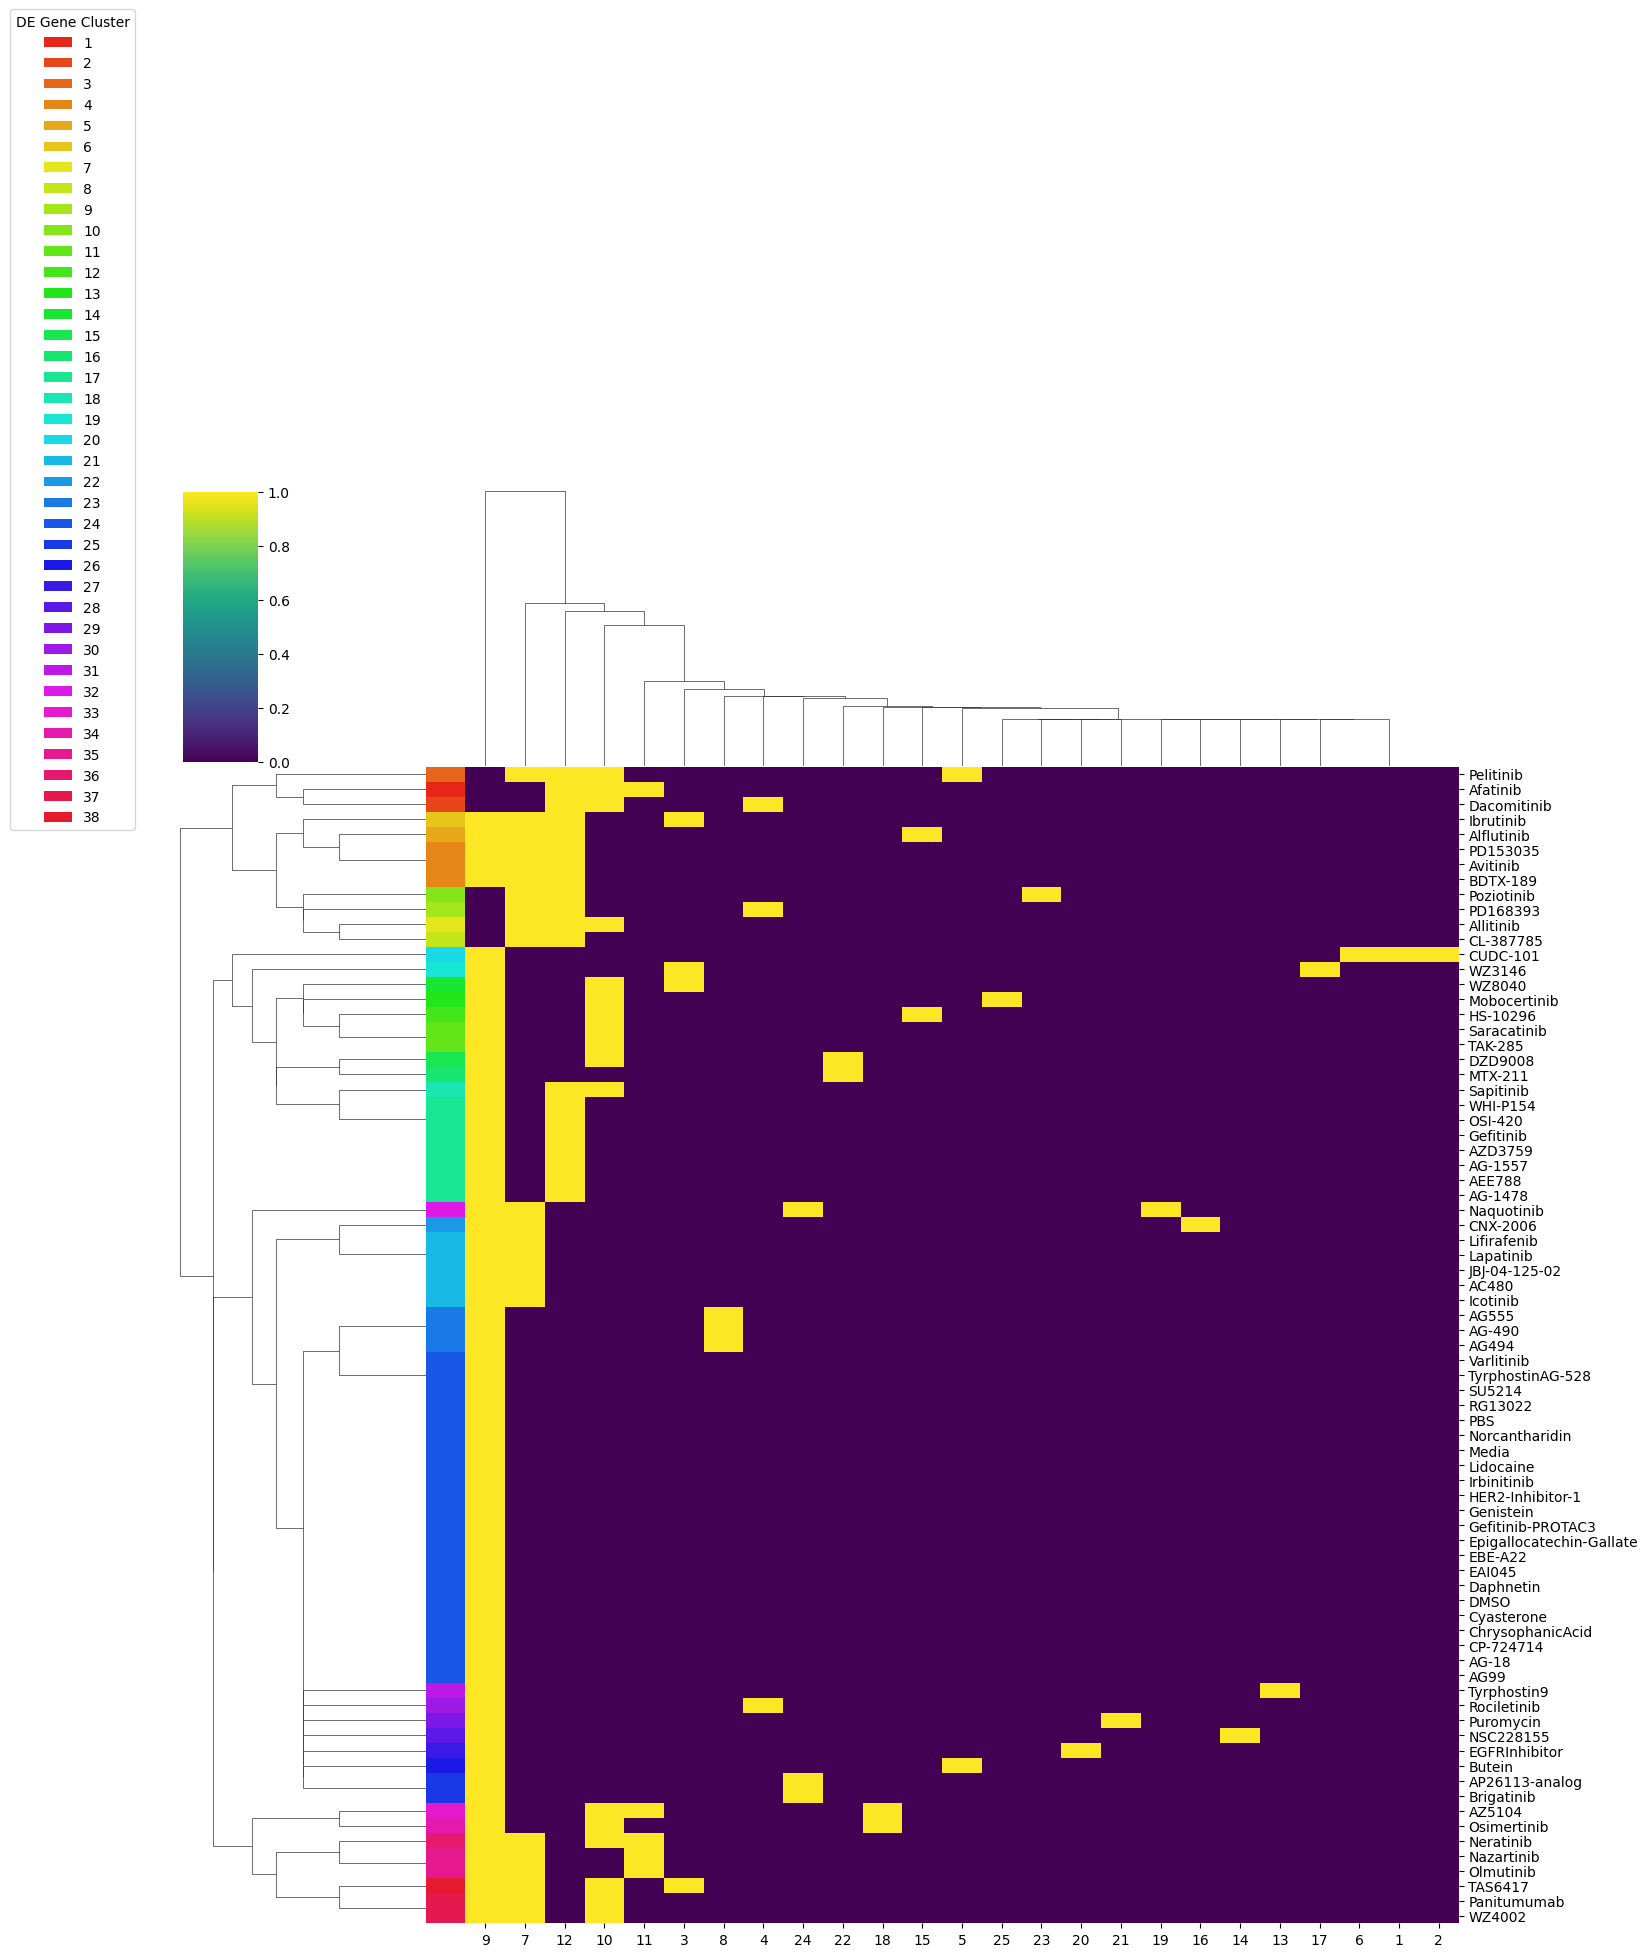

In [31]:
# Create a binary data frame for presence of drug in the response class

drug_class_drugdose_df = pd.DataFrame(0,
                                      index=np.unique(adata_mini.obs['drug_name']).tolist(),
                                      columns=np.arange(1,n_clusters+1))

drug_cluster_labels=drug_cluster

for i in range(len(drug_cluster_labels)):
    drugname = drug_cluster_labels.index[i][:-4]
    drug_class_drugdose_df.loc[drugname,drug_cluster_labels.iloc[i][0]] = 1
    
# CLUSTERMAP 

cluster_method = 'complete'

row_linkage = hierarchy.linkage(
    distance.pdist(drug_class_drugdose_df), 
    method=cluster_method
)

# row_col_labels = fcluster(row_linkage, t=1.5, criterion='distance')
row_col_labels = fcluster(row_linkage, t=0.5, criterion='distance')
lut = dict(zip(set(row_col_labels), sns.hls_palette(len(set(row_col_labels)), l=0.5, s=0.8)))
row_col = pd.DataFrame(row_col_labels)[0].map(lut)

g = sns.clustermap(
        drug_class_drugdose_df,
        cmap='viridis',
        xticklabels=True,
        row_linkage=row_linkage,
        row_colors = [row_col],
        yticklabels=True,
        figsize=(15,15)
)

for label in np.unique(row_col_labels):
    g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='DE Gene Cluster', loc="lower left",
                               bbox_to_anchor=(-0.1, 0.75), bbox_transform=gcf().transFigure)

plt.show()

In [32]:
# Save drug group labels 

pd.DataFrame(row_col_labels, index = drug_class_drugdose_df.index).to_csv('bt333_DrugGroupLabels_01182024.csv')

# Inspect sample unaware cell representation u

In [59]:
adata_u = sc.AnnData(
    adata_mrvi.obsm['X_BT333_mini_u'],
    obs = adata_mrvi.obs,
    uns = adata_mrvi.uns
)
adata_u

AnnData object with n_obs × n_vars = 38340 × 10
    obs: 'cell_line', 'drug_name', 'replicate', 'drug_dose', 'drug_name_dose', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'model_name', 'latent_keys'

In [60]:
sc.pp.pca(adata_u,use_highly_variable=False)
sc.pp.neighbors(adata_u, n_neighbors=50, n_pcs=0)
sc.tl.umap(adata_u, min_dist=0.1)

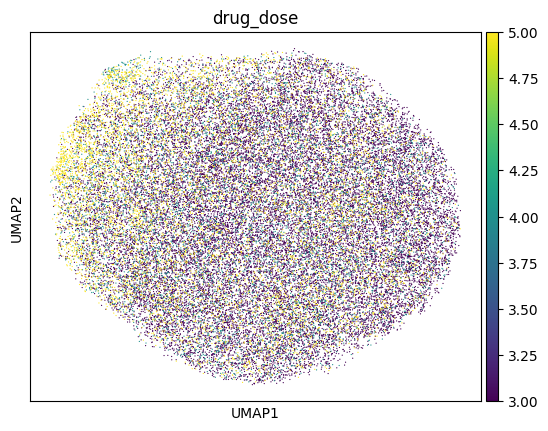

In [61]:
sc.pl.umap(adata_u,
           color=['drug_dose'],
           vmin=3, vmax=5,
           ncols=1)

# Inspect sample aware cell representation z

In [63]:
adata_z = sc.AnnData(
    adata_mrvi.obsm['X_BT333_mini_z'],
    obs = adata_mrvi.obs,
    uns = adata_mrvi.uns
)
adata_z

AnnData object with n_obs × n_vars = 38340 × 30
    obs: 'cell_line', 'drug_name', 'replicate', 'drug_dose', 'drug_name_dose', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'model_name', 'latent_keys', 'pca', 'neighbors', 'umap'

In [64]:
sc.pp.pca(adata_z,use_highly_variable=False)
sc.pp.neighbors(adata_z, n_neighbors=50, n_pcs=0)
sc.tl.umap(adata_z, min_dist=0.1)

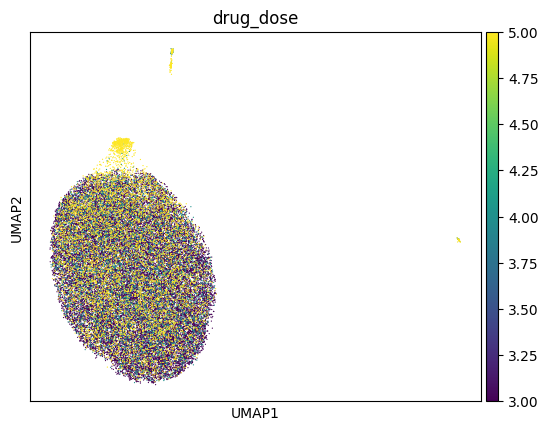

In [65]:
sc.pl.umap(adata_z,
           color=['drug_dose'],
           vmin=3, vmax=5,
           ncols=1)